<a href="https://colab.research.google.com/github/neelkanthrawat/GNN-exercises/blob/main/Assignment_2-Feedback/autoencoders-commented.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Two-dimensional data with bottleneck

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

In [ ]:
# adding something to see how the model works and to

Create sklearn.datasets.make_moons() data sets of varying sizes

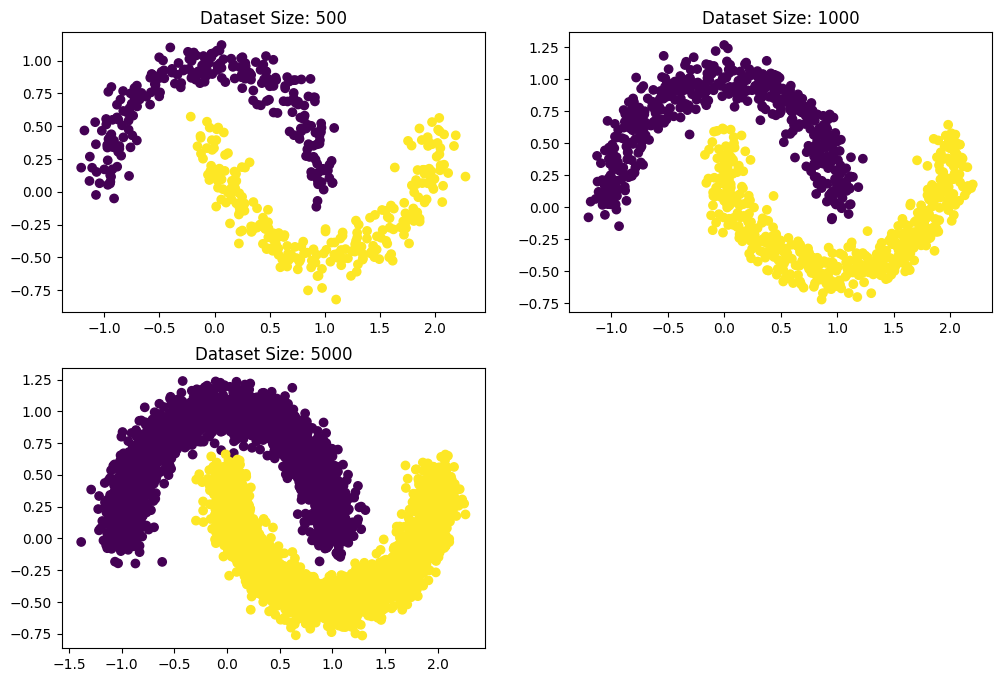

In [ ]:
dataset_sizes = [ 500, 1000, 5000]

# Generate datasets of varying sizes
train_datasets = {}
val_datasets = {}
datasets = {}

for size in dataset_sizes:
    X, y = make_moons(n_samples=size, noise=0.1)
    datasets[size] = {'X': X, 'y': y}
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    train_datasets[size] = {'X': torch.FloatTensor(X_train), 'y': y_train}
    val_datasets[size] = {'X': torch.FloatTensor(X_test), 'y': y_test}

# Visualize the training datasets
plt.figure(figsize=(12, 8))

for i, size in enumerate(dataset_sizes, 1):
    plt.subplot(2, 2, i)
    plt.scatter(datasets[size]['X'][:, 0], datasets[size]['X'][:, 1], c=datasets[size]['y'])
    plt.title(f'Dataset Size: {size}')

plt.show()

<div style="color: green; font-weight:bold">Comment</div>
We created datasets of varying sizes, which is not present in the sample solution, but was a requirement by the exercise sheet. Also we didn't implement a standard scaler, however, it wasn't required by the task.

Next we implement the Autoencoder class with variable length of hidden layers

In [ ]:
# Autoencoder model class
class Autoencoder(nn.Module):
    def __init__(self, input_size, bottleneck_size, hidden_size, layers):
        super(Autoencoder, self).__init__()

        encoder_layers = []
        decoder_layers = []

        encoder_layers.append(nn.Linear(input_size, hidden_size))
        encoder_layers.append(nn.ReLU())
        decoder_layers.append(nn.Linear(bottleneck_size, hidden_size))
        decoder_layers.append(nn.ReLU())

        # Encoder and Decoder layers
        for _ in range(layers):
            encoder_layers.append(nn.Linear(hidden_size, hidden_size))
            encoder_layers.append(nn.ReLU())
            decoder_layers.append(nn.Linear(hidden_size, hidden_size))
            decoder_layers.append(nn.ReLU())

        encoder_layers.append(nn.Linear(hidden_size, bottleneck_size))
        decoder_layers.append(nn.Linear(hidden_size, input_size))

        # Combine encoder and decoder
        self.encoder = nn.Sequential(*encoder_layers)
        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

<div style="color: green; font-weight:bold">Comment</div>
The layers variable was described as "number of hidden layers", the sample solution therefore is wrong in its implementation, since layers are there defines as the total number of layers including input and output layers. We fist defined the layers and than passed them into a nn.Sequential the sample solution directly works with nn.Sequentials, but the end result is the same. We are missing encode and decode function however the encoder and decoder can be acessed trough model.encoder() and model.decoder().

Lets define the training and testing function with the demanded parameters

In [ ]:
# Training function
def train_autoencoder(model, train_datasets, val_datasets,
                      dataset_size=1000, num_epochs=100,
                      batch_size=32, learning_rate=0.001):


    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Data loader
    train_loader = torch.utils.data.DataLoader(train_datasets[dataset_size]['X'], batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_datasets[dataset_size]['X'], batch_size=batch_size, shuffle=True)

    epoch_train_losses = []  # List to store the loss for each epoch
    epoch_val_losses = []  # List to store the loss for each epoch
    for epoch in range(num_epochs):
        train_batch_losses = []
        val_batch_losses = []
        for batch in train_loader:
            # Forward pass
            outputs = model(batch)

            # Compute the loss
            loss = criterion(outputs, batch)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_batch_losses.append(loss.item())

        for batch in val_loader:
            outputs = model(batch)
            loss = criterion(outputs, batch)
            val_batch_losses.append(loss.item())

        # Calculate and store the mean loss for the epoch
        epoch_train_loss = sum(train_batch_losses) / len(train_batch_losses)
        epoch_train_losses.append(epoch_train_loss)

        epoch_val_loss = sum(val_batch_losses) / len(val_batch_losses)
        epoch_val_losses.append(epoch_val_loss)
        # Print the mean loss every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_train_loss:.4f}')
    return epoch_train_losses, epoch_val_losses

<div style="color: green; font-weight:bold">Comment</div>
The approach is quite different than the sample solution, but works in a similar way. We used pytorchs DataLoader to load the data for training and validation sets. Also we validated the network for each epoch, so both graphs can easily be plotted together.

Checking training functionality:

In [ ]:
# Create and train the autoencoder
input_size = 2
bottleneck_size = 1
hidden_size = 100
layers = 2
dataset_size=1000


autoencoder = Autoencoder(input_size, bottleneck_size, hidden_size, layers)
_,_ = train_autoencoder(autoencoder, train_datasets, val_datasets,dataset_size=1000,num_epochs=200)

Epoch [10/200], Loss: 0.0477
Epoch [20/200], Loss: 0.0318
Epoch [30/200], Loss: 0.0160
Epoch [40/200], Loss: 0.0119
Epoch [50/200], Loss: 0.0094
Epoch [60/200], Loss: 0.0079
Epoch [70/200], Loss: 0.0087
Epoch [80/200], Loss: 0.0077
Epoch [90/200], Loss: 0.0069
Epoch [100/200], Loss: 0.0072
Epoch [110/200], Loss: 0.0063
Epoch [120/200], Loss: 0.0066
Epoch [130/200], Loss: 0.0070
Epoch [140/200], Loss: 0.0062
Epoch [150/200], Loss: 0.0065
Epoch [160/200], Loss: 0.0065
Epoch [170/200], Loss: 0.0074
Epoch [180/200], Loss: 0.0067
Epoch [190/200], Loss: 0.0063
Epoch [200/200], Loss: 0.0066


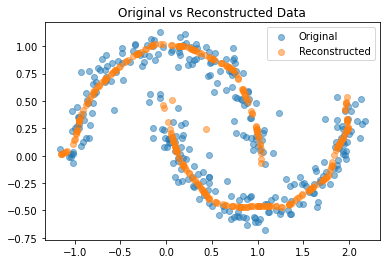

In [ ]:
# Function to visualize original and reconstructed data
def visualize_results(model, data):
    with torch.no_grad():
        reconstructed_data = model(data)

    # Convert PyTorch tensors to numpy arrays
    data_np = data.numpy()
    reconstructed_np = reconstructed_data.numpy()

    # Plot original and reconstructed data
    plt.scatter(data_np[:, 0], data_np[:, 1], label='Original', alpha=0.5)
    plt.scatter(reconstructed_np[:, 0], reconstructed_np[:, 1], label='Reconstructed', alpha=0.5)
    plt.title('Original vs Reconstructed Data')
    plt.legend()
    plt.show()

# Visualize results on the test dataset
visualize_results(autoencoder, val_datasets[dataset_size]['X'])

<div style="color: green; font-weight:bold">Comment</div>
While there exist some difference in implementation, our solution has the same result with the subset following the moons centerlines.

## 1.1 Hyperparameter search

In [ ]:
# Define the hyperparameter values to explore
hidden_sizes = [50, 100, 200]
layers = [2, 5, 10]
learning_rates = [0.0005, 0.001, 0.002 ,0.003]
epochs = [100,250,500]
dataset_sizes = [500, 1000, 5000]

In order to not a have a exploding search space, we first analyze the number of epochs in relation to the dataset size

Epoch [10/400], Loss: 0.0627
Epoch [20/400], Loss: 0.0409
Epoch [30/400], Loss: 0.0375
Epoch [40/400], Loss: 0.0314
Epoch [50/400], Loss: 0.0245
Epoch [60/400], Loss: 0.0161
Epoch [70/400], Loss: 0.0148
Epoch [80/400], Loss: 0.0097
Epoch [90/400], Loss: 0.0077
Epoch [100/400], Loss: 0.0090
Epoch [110/400], Loss: 0.0107
Epoch [120/400], Loss: 0.0075
Epoch [130/400], Loss: 0.0070
Epoch [140/400], Loss: 0.0076
Epoch [150/400], Loss: 0.0073
Epoch [160/400], Loss: 0.0067
Epoch [170/400], Loss: 0.0062
Epoch [180/400], Loss: 0.0071
Epoch [190/400], Loss: 0.0061
Epoch [200/400], Loss: 0.0062
Epoch [210/400], Loss: 0.0073
Epoch [220/400], Loss: 0.0070
Epoch [230/400], Loss: 0.0069
Epoch [240/400], Loss: 0.0059
Epoch [250/400], Loss: 0.0065
Epoch [260/400], Loss: 0.0062
Epoch [270/400], Loss: 0.0063
Epoch [280/400], Loss: 0.0059
Epoch [290/400], Loss: 0.0057
Epoch [300/400], Loss: 0.0059
Epoch [310/400], Loss: 0.0060
Epoch [320/400], Loss: 0.0063
Epoch [330/400], Loss: 0.0057
Epoch [340/400], Lo

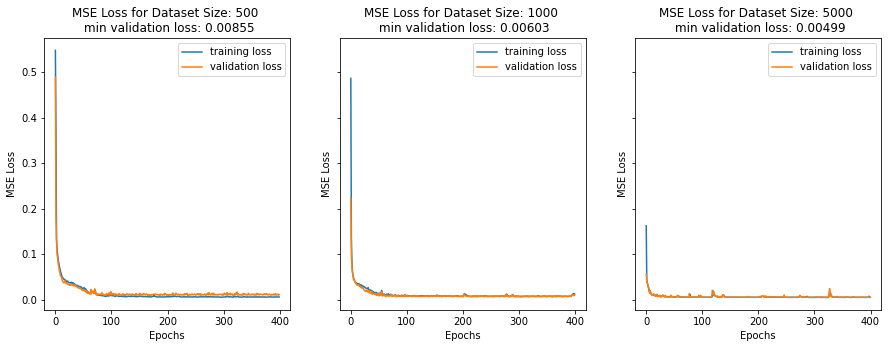

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
for i, dataset_size in enumerate(dataset_sizes):
    autoencoder = Autoencoder(input_size, bottleneck_size, hidden_size = 100, layers = 2)
    train_losses, val_losses = train_autoencoder(autoencoder, train_datasets,val_datasets, dataset_size=dataset_size, num_epochs=400)
    axes[i].plot(train_losses, label='training loss')
    axes[i].plot(val_losses, label='validation loss')
    axes[i].set_title('MSE Loss for Dataset Size: {} \n min validation loss: {:.5f}'.format(dataset_size, min(val_losses)))
    axes[i].set_xlabel('Epochs')
    axes[i].set_ylabel('MSE Loss')
    axes[i].legend()



The best performance is achieved for the biggest dataset, however the dataset with 1000 entries is almost just as good and substantially faster. Therefore, we choose the continue with this medium sized dataset and let the training run to 200 epochs for now

Epoch [10/300], Loss: 0.0442
Epoch [20/300], Loss: 0.0336
Epoch [30/300], Loss: 0.0310
Epoch [40/300], Loss: 0.0282
Epoch [50/300], Loss: 0.0202
Epoch [60/300], Loss: 0.0155
Epoch [70/300], Loss: 0.0144
Epoch [80/300], Loss: 0.0124
Epoch [90/300], Loss: 0.0114
Epoch [100/300], Loss: 0.0098
Epoch [110/300], Loss: 0.0094
Epoch [120/300], Loss: 0.0089
Epoch [130/300], Loss: 0.0094
Epoch [140/300], Loss: 0.0088
Epoch [150/300], Loss: 0.0095
Epoch [160/300], Loss: 0.0077
Epoch [170/300], Loss: 0.0077
Epoch [180/300], Loss: 0.0078
Epoch [190/300], Loss: 0.0095
Epoch [200/300], Loss: 0.0089
Epoch [210/300], Loss: 0.0080
Epoch [220/300], Loss: 0.0073
Epoch [230/300], Loss: 0.0072
Epoch [240/300], Loss: 0.0076
Epoch [250/300], Loss: 0.0078
Epoch [260/300], Loss: 0.0074
Epoch [270/300], Loss: 0.0077
Epoch [280/300], Loss: 0.0075
Epoch [290/300], Loss: 0.0075
Epoch [300/300], Loss: 0.0073
Epoch [10/300], Loss: 0.0368
Epoch [20/300], Loss: 0.0291
Epoch [30/300], Loss: 0.0219
Epoch [40/300], Loss: 

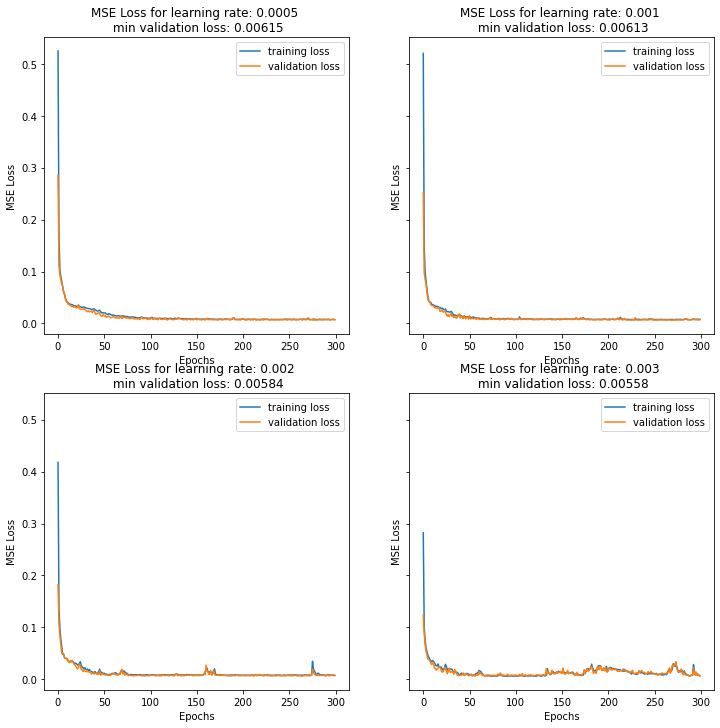

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12), sharey=True)
for i, learning_rate in enumerate(learning_rates):
    autoencoder = Autoencoder(input_size, bottleneck_size, hidden_size = 100, layers = 2)
    train_losses, val_losses = train_autoencoder(autoencoder, train_datasets,val_datasets, dataset_size=1000, num_epochs=300, learning_rate=learning_rate)

    # Use two indices to access the correct subplot
    row = i // 2  # Integer division to get the row index
    col = i % 2   # Modulo operation to get the column index

    axes[row, col].plot(train_losses, label='training loss')
    axes[row, col].plot(val_losses, label='validation loss')
    axes[row, col].set_title('MSE Loss for learning rate: {} \n min validation loss: {:.5f}'.format(learning_rate, min(val_losses)))
    axes[row, col].set_xlabel('Epochs')
    axes[row, col].set_ylabel('MSE Loss')
    axes[row, col].legend()

We see, with this autoencoder architecture, the learning rate does not have a great impact on training results. Nevertheless, training with larger learning rates is faster but we one can see, that the training is more unstable as well. Thus, we continue with a learning rate of 0.001 for 200 epochs. Now lets see, if we can improve the network hyperparameters

Epoch [10/200], Loss: 0.0534
Epoch [20/200], Loss: 0.0364
Epoch [30/200], Loss: 0.0313
Epoch [40/200], Loss: 0.0271
Epoch [50/200], Loss: 0.0220
Epoch [60/200], Loss: 0.0175
Epoch [70/200], Loss: 0.0146
Epoch [80/200], Loss: 0.0121
Epoch [90/200], Loss: 0.0113
Epoch [100/200], Loss: 0.0120
Epoch [110/200], Loss: 0.0093
Epoch [120/200], Loss: 0.0091
Epoch [130/200], Loss: 0.0094
Epoch [140/200], Loss: 0.0084
Epoch [150/200], Loss: 0.0087
Epoch [160/200], Loss: 0.0085
Epoch [170/200], Loss: 0.0080
Epoch [180/200], Loss: 0.0087
Epoch [190/200], Loss: 0.0080
Epoch [200/200], Loss: 0.0083
Epoch [10/200], Loss: 0.0694
Epoch [20/200], Loss: 0.0517
Epoch [30/200], Loss: 0.0366
Epoch [40/200], Loss: 0.0279
Epoch [50/200], Loss: 0.0237
Epoch [60/200], Loss: 0.0216
Epoch [70/200], Loss: 0.0192
Epoch [80/200], Loss: 0.0196
Epoch [90/200], Loss: 0.0196
Epoch [100/200], Loss: 0.0151
Epoch [110/200], Loss: 0.0162
Epoch [120/200], Loss: 0.0089
Epoch [130/200], Loss: 0.0078
Epoch [140/200], Loss: 0.007

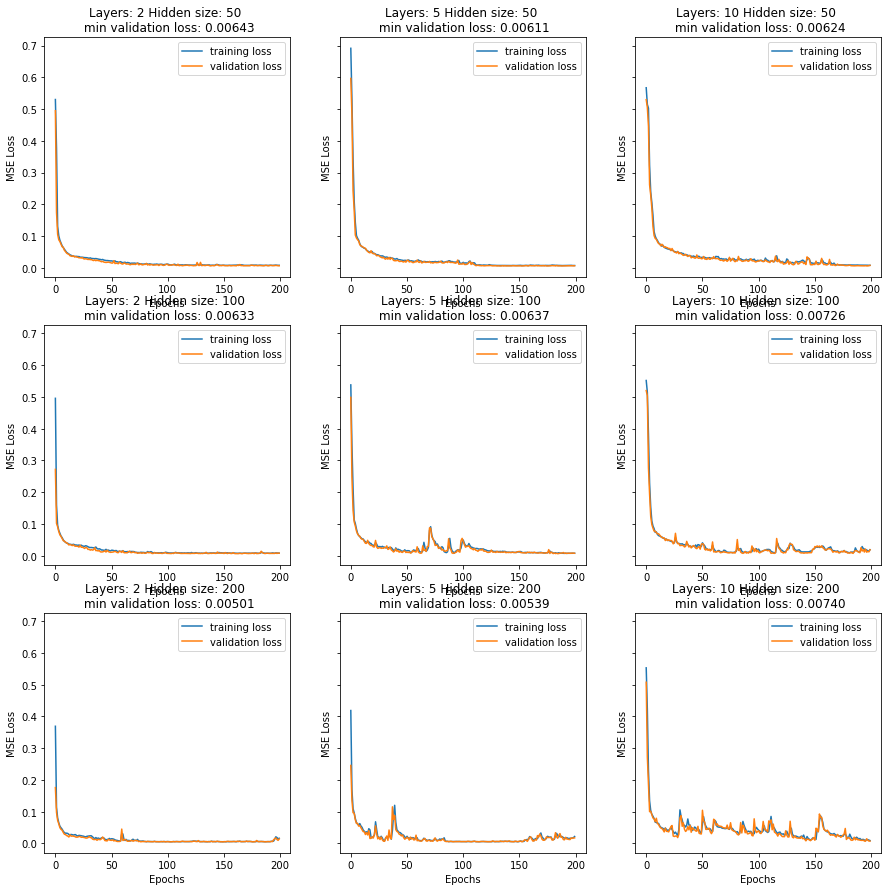

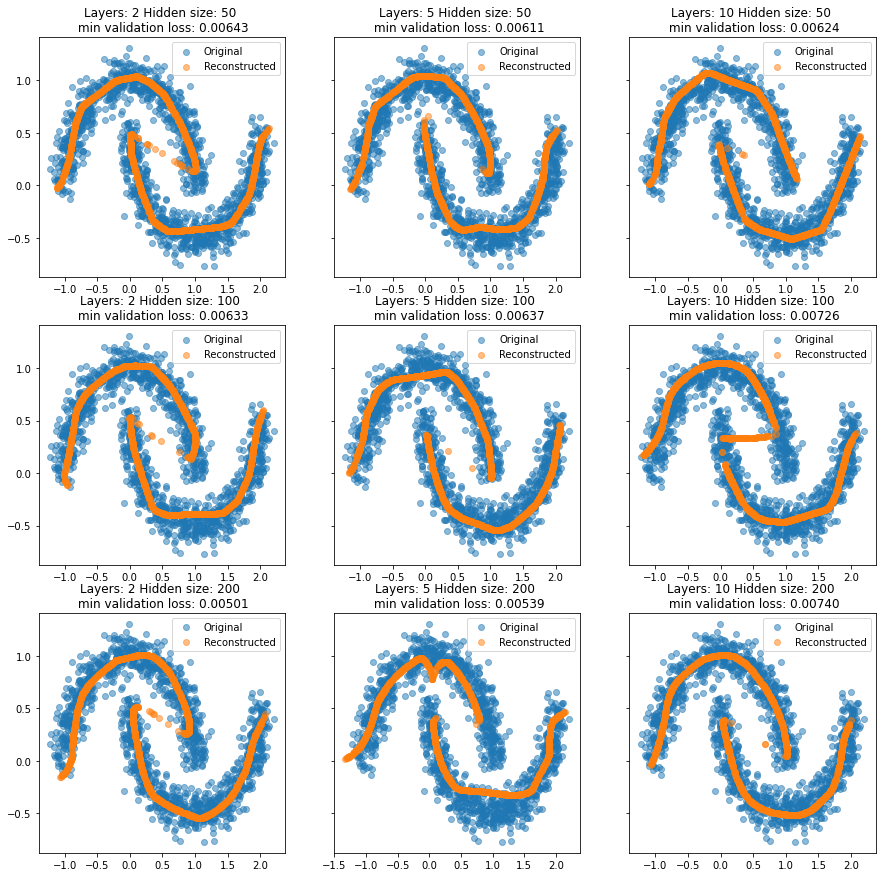

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15), sharey=True)
fig_2, axes_2 = plt.subplots(3, 3, figsize=(15, 15), sharey=True)

for i, hidden_size in enumerate(hidden_sizes):
    for j, num_layers in enumerate(layers):
        autoencoder = Autoencoder(input_size, bottleneck_size, hidden_size = hidden_size, layers = num_layers)
        train_losses, val_losses = train_autoencoder(autoencoder, train_datasets,val_datasets, dataset_size=1000, num_epochs=200, learning_rate=0.001)

        axes[i, j].plot(train_losses, label='training loss')
        axes[i, j].plot(val_losses, label='validation loss')
        axes[i, j].set_title('Layers: {} Hidden size: {} \n min validation loss: {:.5f}'.format(num_layers, hidden_size, min(val_losses)))
        axes[i, j].set_xlabel('Epochs')
        axes[i, j].set_ylabel('MSE Loss')
        axes[i, j].legend()

        val_data = val_datasets[dataset_size]['X']
        with torch.no_grad():
            reconstructed_data = autoencoder(val_data)

        # Convert PyTorch tensors to numpy arrays
        data_np = val_data.numpy()
        reconstructed_np = reconstructed_data.numpy()

        # Plot original and reconstructed data
        axes_2[i, j].scatter(data_np[:, 0], data_np[:, 1], label='Original', alpha=0.5)
        axes_2[i, j].scatter(reconstructed_np[:, 0], reconstructed_np[:, 1], label='Reconstructed', alpha=0.5)
        axes_2[i, j].set_title('Layers: {} Hidden size: {} \n min validation loss: {:.5f}'.format(num_layers, hidden_size, min(val_losses)))
        axes_2[i, j].legend()

Epoch [10/150], Loss: 0.0614
Epoch [20/150], Loss: 0.0370
Epoch [30/150], Loss: 0.0332
Epoch [40/150], Loss: 0.0302
Epoch [50/150], Loss: 0.0280
Epoch [60/150], Loss: 0.0221
Epoch [70/150], Loss: 0.0166
Epoch [80/150], Loss: 0.0135
Epoch [90/150], Loss: 0.0118
Epoch [100/150], Loss: 0.0109
Epoch [110/150], Loss: 0.0110
Epoch [120/150], Loss: 0.0093
Epoch [130/150], Loss: 0.0090
Epoch [140/150], Loss: 0.0091
Epoch [150/150], Loss: 0.0089
Epoch [10/150], Loss: 0.0758
Epoch [20/150], Loss: 0.0527
Epoch [30/150], Loss: 0.0411
Epoch [40/150], Loss: 0.0302
Epoch [50/150], Loss: 0.0261
Epoch [60/150], Loss: 0.0188
Epoch [70/150], Loss: 0.0156
Epoch [80/150], Loss: 0.0109
Epoch [90/150], Loss: 0.0113
Epoch [100/150], Loss: 0.0096
Epoch [110/150], Loss: 0.0130
Epoch [120/150], Loss: 0.0182
Epoch [130/150], Loss: 0.0130
Epoch [140/150], Loss: 0.0068
Epoch [150/150], Loss: 0.0059
Epoch [10/150], Loss: 0.0803
Epoch [20/150], Loss: 0.0549
Epoch [30/150], Loss: 0.0393
Epoch [40/150], Loss: 0.0308
Ep

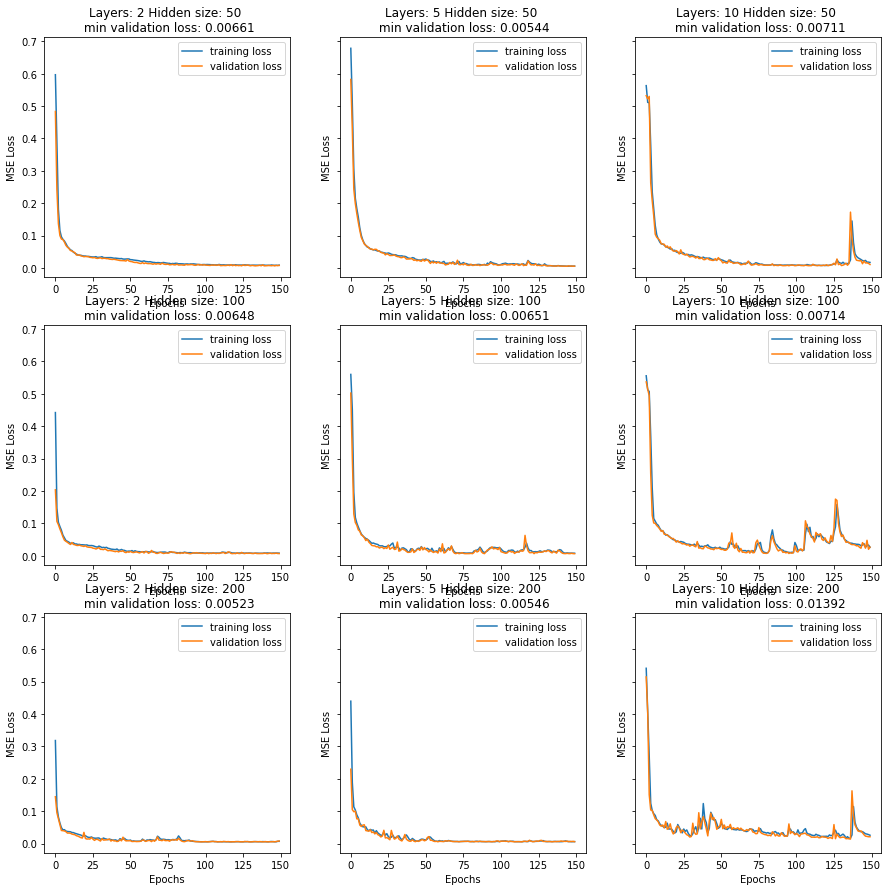

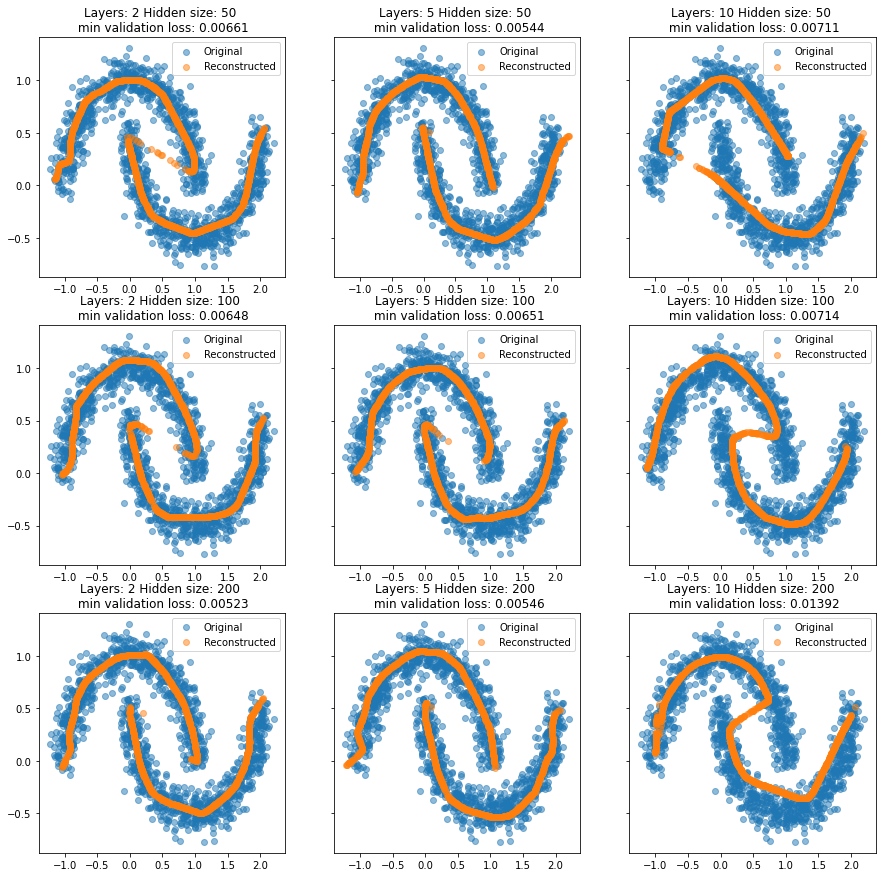

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15), sharey=True)
fig_2, axes_2 = plt.subplots(3, 3, figsize=(15, 15), sharey=True)

for i, hidden_size in enumerate(hidden_sizes):
    for j, num_layers in enumerate(layers):
        autoencoder = Autoencoder(input_size, bottleneck_size, hidden_size = hidden_size, layers = num_layers)
        train_losses, val_losses = train_autoencoder(autoencoder, train_datasets,val_datasets, dataset_size=1000, num_epochs=150, learning_rate=0.001)

        axes[i, j].plot(train_losses, label='training loss')
        axes[i, j].plot(val_losses, label='validation loss')
        axes[i, j].set_title('Layers: {} Hidden size: {} \n min validation loss: {:.5f}'.format(num_layers, hidden_size, min(val_losses)))
        axes[i, j].set_xlabel('Epochs')
        axes[i, j].set_ylabel('MSE Loss')
        axes[i, j].legend()

        val_data = val_datasets[dataset_size]['X']
        with torch.no_grad():
            reconstructed_data = autoencoder(val_data)

        # Convert PyTorch tensors to numpy arrays
        data_np = val_data.numpy()
        reconstructed_np = reconstructed_data.numpy()

        # Plot original and reconstructed data
        axes_2[i, j].scatter(data_np[:, 0], data_np[:, 1], label='Original', alpha=0.5)
        axes_2[i, j].scatter(reconstructed_np[:, 0], reconstructed_np[:, 1], label='Reconstructed', alpha=0.5)
        axes_2[i, j].set_title('Layers: {} Hidden size: {} \n min validation loss: {:.5f}'.format(num_layers, hidden_size, min(val_losses)))
        axes_2[i, j].legend()

<div style="color: green; font-weight:bold">Comment</div>
We follow the same approach to hyperparameter tuning with having all parameters exept one parameter fixed and are doing it for all hyperparameters, The sample solution also optimizes the batch_size, even though it wasn't required. Since many hyperparameter this approach however is debadable this, many hyparparameter depend on each other like learning rate and epochs. Thus, the sample solution should have compared more hyperparameter in a grid search manner. Also we analyzed mainly on the learning rates and only secondary on the reconstruction images.

## 2.2
Repeating the same trainig with all dataset sizes

Epoch [10/150], Loss: 0.0481
Epoch [20/150], Loss: 0.0362
Epoch [30/150], Loss: 0.0299
Epoch [40/150], Loss: 0.0251
Epoch [50/150], Loss: 0.0148
Epoch [60/150], Loss: 0.0129
Epoch [70/150], Loss: 0.0149
Epoch [80/150], Loss: 0.0100
Epoch [90/150], Loss: 0.0100
Epoch [100/150], Loss: 0.0086
Epoch [110/150], Loss: 0.0094
Epoch [120/150], Loss: 0.0091
Epoch [130/150], Loss: 0.0080
Epoch [140/150], Loss: 0.0073
Epoch [150/150], Loss: 0.0068
Epoch [10/150], Loss: 0.0360
Epoch [20/150], Loss: 0.0245
Epoch [30/150], Loss: 0.0197
Epoch [40/150], Loss: 0.0156
Epoch [50/150], Loss: 0.0117
Epoch [60/150], Loss: 0.0096
Epoch [70/150], Loss: 0.0089
Epoch [80/150], Loss: 0.0080
Epoch [90/150], Loss: 0.0127
Epoch [100/150], Loss: 0.0082
Epoch [110/150], Loss: 0.0082
Epoch [120/150], Loss: 0.0132
Epoch [130/150], Loss: 0.0098
Epoch [140/150], Loss: 0.0068
Epoch [150/150], Loss: 0.0058
Epoch [10/150], Loss: 0.0130
Epoch [20/150], Loss: 0.0086
Epoch [30/150], Loss: 0.0156
Epoch [40/150], Loss: 0.0086
Ep

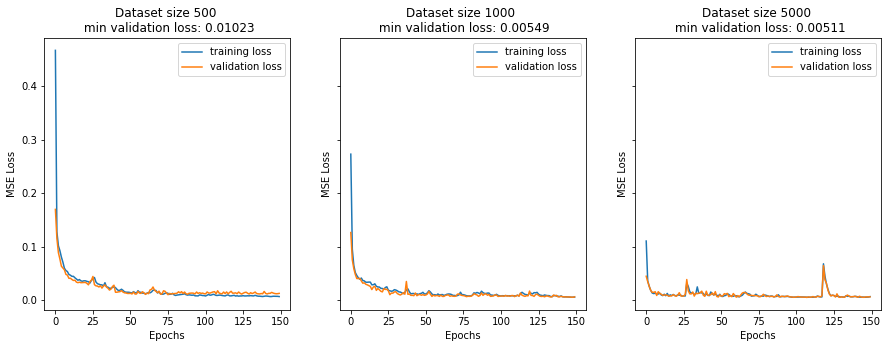

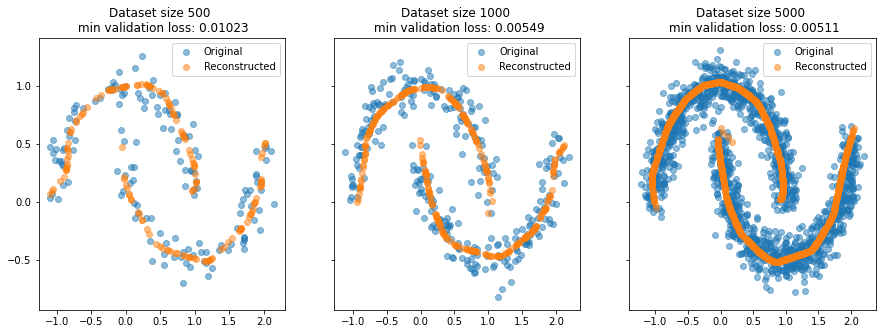

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig_2, axes_2 = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

for i, dataset_size in enumerate(dataset_sizes):
        autoencoder = Autoencoder(input_size, bottleneck_size, hidden_size = 200, layers = 2)
        train_losses, val_losses = train_autoencoder(autoencoder, train_datasets,val_datasets, dataset_size=dataset_size, num_epochs=150, learning_rate=0.001)

        axes[i].plot(train_losses, label='training loss')
        axes[i].plot(val_losses, label='validation loss')
        axes[i].set_title('Dataset size {} \n min validation loss: {:.5f}'.format(dataset_size, min(val_losses)))
        axes[i].set_xlabel('Epochs')
        axes[i].set_ylabel('MSE Loss')
        axes[i].legend()

        val_data = val_datasets[dataset_size]['X']
        with torch.no_grad():
            reconstructed_data = autoencoder(val_data)

        # Convert PyTorch tensors to numpy arrays
        data_np = val_data.numpy()
        reconstructed_np = reconstructed_data.numpy()

        # Plot original and reconstructed data
        axes_2[i].scatter(data_np[:, 0], data_np[:, 1], label='Original', alpha=0.5)
        axes_2[i].scatter(reconstructed_np[:, 0], reconstructed_np[:, 1], label='Reconstructed', alpha=0.5)
        axes_2[i].set_title('Dataset size {} \n min validation loss: {:.5f}'.format(dataset_size, min(val_losses)))
        axes_2[i].legend()

unsuspectedly the resuts are quite good for all dataset size. But one can see, that the training doesnt need as many epoch with the large dataset and already started to be incoherant

<div style="color: green; font-weight:bold">Comment</div>
We understood the assignment differently, we investigated the different dataset sizes again and not the different generated datasets with the same size

## 2.3
Visualization of code distribution with histogram

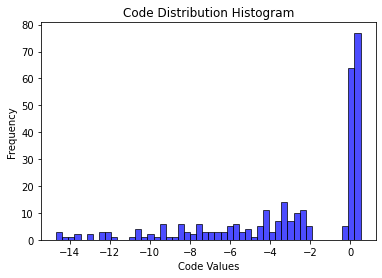

In [ ]:
from sklearn.mixture import GaussianMixture
import numpy as np

val_loader = torch.utils.data.DataLoader(val_datasets[1000]['X'], batch_size=1, shuffle=True)
autoencoder.eval()

# Create empty list to store code representations
code_list = []
reconstructed_data = []

# Iterate over batches in the test dataset and extract code representations
with torch.no_grad():
    for data in val_loader:
        outputs = autoencoder.encoder(data)
        reconstructed = autoencoder(data)
        code_list.append(outputs.numpy())
        reconstructed_data.append(reconstructed.numpy())

# Concatenate code representations from all batches
all_codes = np.concatenate(code_list, axis=0)
reconstructed_data = np.stack(reconstructed_data)
reconstructed_data = np.squeeze(reconstructed_data)

# Visualize histogram
plt.hist(all_codes, bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.title('Code Distribution Histogram')
plt.xlabel('Code Values')
plt.ylabel('Frequency')
plt.show()

c:\Users\luke\anaconda3\envs\ml_homework\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


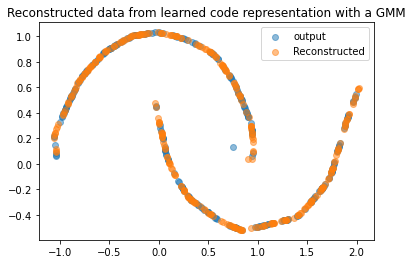

In [ ]:
n_components = 20
gmm = GaussianMixture(n_components=n_components)
gmm.fit(all_codes)
new_samples, _ = gmm.sample(len(all_codes))
new_samples = torch.tensor(new_samples, dtype=torch.float32)
output_data = []
for i in range(len(all_codes)):
    output = autoencoder.decoder(new_samples[i])
    output_data.append(output.detach().numpy())

output_data = np.stack(output_data, axis=0)

plt.scatter(output_data[:, 0], output_data[:, 1], label='output', alpha=0.5)
plt.scatter(reconstructed_data[:, 0], reconstructed_data[:, 1], label='Reconstructed', alpha=0.5)
plt.title('Reconstructed data from learned code representation with a GMM')
plt.legend()

The GMM menages to learn the code representation of the Autoencoder successfully, thus the autoencoder is able the reconstruct the distributions from the sampled code representations

<div style="color: green; font-weight:bold">Comment</div>
Our histogram only shows the negative side and not also the positive side, we therefore missed the interpretation. The GMM model implementation is correct but plotted with the code distribution and not with the test dataset.

## 1.4 At noise level 0.2


In [ ]:
dataset_size = 1000
new_X,new_y = make_moons(n_samples=dataset_size, noise=0.2)
X_train, X_test, y_train, y_test = train_test_split(new_X, new_y, test_size=0.3, random_state=42)
new_data = new_X
new_train_dataset = {}
new_val_dataset = {}
new_train_dataset[dataset_size] = {'X': torch.FloatTensor(X_train), 'y': y_train}
new_val_dataset[dataset_size] = {'X': torch.FloatTensor(X_test), 'y': y_test}

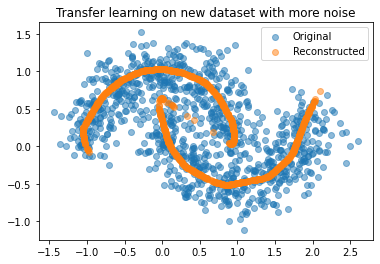

In [ ]:
inputs = torch.tensor(new_data,dtype=torch.float32)
with torch.no_grad():
    reconstructed_data = autoencoder(inputs)

# Convert PyTorch tensors to numpy arrays
reconstructed_np = reconstructed_data.numpy()

# Plot original and reconstructed data
plt.scatter(new_data[:, 0], new_data[:, 1], label='Original', alpha=0.5)
plt.scatter(reconstructed_np[:, 0], reconstructed_np[:, 1], label='Reconstructed', alpha=0.5)
plt.title('Transfer learning on new dataset with more noise')
plt.legend()

The Autoencoder is able to detect the rough shape but the reconstuction in the middle between the half moons isn't as great

<div style="color: green; font-weight:bold">Comment</div>
Same conclusion and plot as sample solution

## 1.5


Epoch [10/150], Loss: 0.0509
Epoch [20/150], Loss: 0.0384
Epoch [30/150], Loss: 0.0346
Epoch [40/150], Loss: 0.0329
Epoch [50/150], Loss: 0.0298
Epoch [60/150], Loss: 0.0276
Epoch [70/150], Loss: 0.0259
Epoch [80/150], Loss: 0.0287
Epoch [90/150], Loss: 0.0245
Epoch [100/150], Loss: 0.0254
Epoch [110/150], Loss: 0.0235
Epoch [120/150], Loss: 0.0230
Epoch [130/150], Loss: 0.0233
Epoch [140/150], Loss: 0.0238
Epoch [150/150], Loss: 0.0240


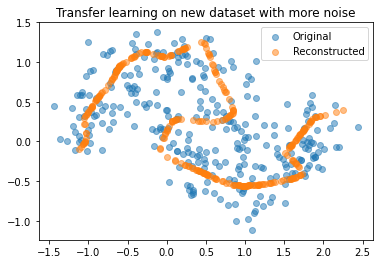

In [ ]:
autoencoder = Autoencoder(input_size, bottleneck_size, hidden_size = 200, layers = 2)
train_losses, val_losses = train_autoencoder(autoencoder, new_train_dataset,new_val_dataset, dataset_size=dataset_size, num_epochs=150, learning_rate=0.001)

val_data = new_val_dataset[dataset_size]['X']
with torch.no_grad():
    reconstructed_data = autoencoder(val_data)

# Convert PyTorch tensors to numpy arrays
data_np = val_data.numpy()
reconstructed_np = reconstructed_data.numpy()

# Plot original and reconstructed data
plt.scatter(data_np[:, 0], data_np[:, 1], label='Original', alpha=0.5)
plt.scatter(reconstructed_np[:, 0], reconstructed_np[:, 1], label='Reconstructed', alpha=0.5)
plt.title('Transfer learning on new dataset with more noise')
plt.legend()

The training with the same learning parameters performs now worse and the autoencoder is not able to reconstruct the correct shape entirely

<div style="color: green; font-weight:bold">Comment</div>
Same conclusion and plot as sample solution

# 2. Two dimensional data without bottleneck
### Additional hyperparameters that came into the picture now:
1. The number of values of the bandwidths in the kernel for the MMD.
2. mmd_weight in the calculation of the loss function.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import numpy as np
import scipy as sp

In [2]:
# Autoencoder model class
class Autoencoder(nn.Module):
    def __init__(self, input_size, bottleneck_size, hidden_size, layers):
        super(Autoencoder, self).__init__()

        encoder_layers = []
        decoder_layers = []

        encoder_layers.append(nn.Linear(input_size, hidden_size))
        encoder_layers.append(nn.ReLU())
        decoder_layers.append(nn.Linear(bottleneck_size, hidden_size))
        decoder_layers.append(nn.ReLU())

        # Encoder and Decoder layers
        for _ in range(layers):
            encoder_layers.append(nn.Linear(hidden_size, hidden_size))
            encoder_layers.append(nn.ReLU())
            decoder_layers.append(nn.Linear(hidden_size, hidden_size))
            decoder_layers.append(nn.ReLU())

        encoder_layers.append(nn.Linear(hidden_size, bottleneck_size))
        decoder_layers.append(nn.Linear(hidden_size, input_size))

        # Combine encoder and decoder
        self.encoder = nn.Sequential(*encoder_layers)
        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

<div style="color: green; font-weight:
bold">Comment:</div>

* We continued with the auto-encoder model (unlike the sample solution which proceeded with the resnet architecture).

In [ ]:
# def squared_exponentials_kernel(x, y, bandwidth):
#     """
#     Compute the squared exponentials kernel between two sets of samples.

#     Args:
#         x (Tensor): Samples from the first distribution.
#         y (Tensor): Samples from the second distribution.
#         bandwidth (float): Bandwidth value for the kernel.

#     Returns:
#         Tensor: Squared exponentials kernel between the two distributions.
#     """
#     norms = (x[:, None] - y[None, :]).norm(dim=-1)
#     return torch.exp(-0.5 * bandwidth**2 * (norms**2))

# import torch

# def mmd_sqd(x, y, bandwidths, kernel_fn):
#     """
#     Compute the Maximum Mean Discrepancy (MMD) between two sets of samples using a given kernel function.

#     Args:
#         x (Tensor): Samples from the first distribution.
#         y (Tensor): Samples from the second distribution.
#         bandwidths (list): List of bandwidth values for the kernel.
#         kernel_fn (function): Kernel function to compute the MMD.

#     Returns:
#         Tensor: Maximum mean discrepancy between the two distributions.
#     """
#     n = x.size(0)
#     m = y.size(0)

#     mmd_sqd_val = 0.0
#     for bandwidth in bandwidths:

#       xx = torch.sum(kernel_fn(x, x, bandwidth) - torch.eye(n).to(x.device) * kernel_fn(x, x, bandwidth))
#       yy = torch.sum(kernel_fn(y, y, bandwidth) - torch.eye(m).to(y.device) * kernel_fn(y, y, bandwidth))

#       # Pairwise sum for 1/(nm)
#       xy = torch.sum(kernel_fn(x, y, bandwidth)) / (n * m)

#       # MMD calculation with appropriate normalization
#       mmd_sqd_val += xx / (n * (n - 1)) + yy / (m * (m - 1)) - 2 * xy

#     return mmd_sqd_val


In [ ]:
# import torch

# def squared_exponentials_kernel(x, y, bandwidth):
#     """
#     Compute the squared exponentials kernel between two sets of samples.

#     Args:
#         x (Tensor): Samples from the first distribution.
#         y (Tensor): Samples from the second distribution.
#         bandwidth (float): Bandwidth value for the kernel.

#     Returns:
#         Tensor: Squared exponentials kernel between the two distributions.
#     """
#     norms = (x[:, None] - y[None, :]).norm(dim=-1)
#     return torch.exp(-0.5 * bandwidth**2 * norms**2)

# def mmd_sqd(x, y, bandwidths, kernel_fn):
#     """
#     Compute the Maximum Mean Discrepancy (MMD) between two sets of samples using a given kernel function.

#     Args:
#         x (Tensor): Samples from the first distribution.
#         y (Tensor): Samples from the second distribution.
#         bandwidths (list): List of bandwidth values for the kernel.
#         kernel_fn (function): Kernel function to compute the MMD.

#     Returns:
#         Tensor: Maximum mean discrepancy between the two distributions.
#     """
#     n = x.size(0)
#     m = y.size(0)

#     mmd_sqd_val = 0.0
#     for bandwidth in bandwidths:
#         # Compute the kernel values directly for better numerical stability
#         Kxx = kernel_fn(x, x, bandwidth)
#         Kyy = kernel_fn(y, y, bandwidth)
#         Kxy = kernel_fn(x, y, bandwidth)

#         xx = torch.sum(Kxx - torch.eye(n).to(x.device) * Kxx)
#         yy = torch.sum(Kyy - torch.eye(m).to(y.device) * Kyy)
#         xy = torch.sum(Kxy) / (n * m)

#         # MMD calculation with appropriate normalization
#         mmd_sqd_val += xx / (n * (n - 1)) + yy / (m * (m - 1)) - 2 * xy

#     return mmd_sqd_val

# # Example Usage:
# x = torch.randn(100, 2)  # Samples from the first distribution
# y = torch.randn(100, 2)  # Samples from the second distribution
# bandwidths = [0.1, 0.2, 0.4, 0.8, 1.6]

# result = mmd_sqd(x, y, bandwidths, squared_exponentials_kernel)
# print(result)


In [ ]:
### Code to evaluate:
# 1. the squared exponential kernel and
# 2. estimate the value of mmd_squared.
def squared_exponentials_kernel(xa, xb, bandwidth, amplitude=1.0):
    """
    Squared Exponential (RBF) kernel function.

    Args:
    - xa: A PyTorch tensor of shape (n_samples1, n_features).
    - xb: A PyTorch tensor of shape (n_samples2, n_features).
    - bandwidth: Bandwidth parameter.
    - amplitude: Overall variance (default is 1).

    Returns:
    - kernel: The kernel values.
    """
    diff = xa.unsqueeze(1) - xb.unsqueeze(0)
    kernel = (amplitude ** 2) * torch.exp(-torch.sum(diff**2, dim=-1) / (2 * bandwidth**2))
    return kernel

def estimate_mmd_squared(samples1, samples2, kernel_function, bandwidths):
    """
    Estimate the Maximum Mean Discrepancy (MMD) squared between two sets of samples using a kernel function.

    Args:
    - samples1: the first set of samples. A PyTorch tensor of shape (n_samples1, n_features).
    - samples2: the second set of samples. A PyTorch tensor of shape (n_samples2, n_features).
    - kernel_function: A function that computes the kernel value between two samples.
    - bandwidths: List of bandwidth parameters for the kernel function.

    Returns:
    - mmd_squared: The estimated MMD squared.
    """
    num_samples1 = samples1.size(0)
    num_samples2 = samples2.size(0)

    # Compute the MMD squared statistic
    mmd_squared = 0.0

    for bandwidth in bandwidths:
        # Compute the kernel matrices
        Kxx = kernel_function(samples1, samples1, bandwidth)
        Kyy = kernel_function(samples2, samples2, bandwidth)
        Kxy = kernel_function(samples1, samples2, bandwidth)

        # MMD calculation with appropriate normalization
        mmd_squared += torch.sum(Kxx) / (num_samples1 * (num_samples1 - 1))
        mmd_squared += torch.sum(Kyy) / (num_samples2 * (num_samples2 - 1))
        mmd_squared -= 2.0 * torch.sum(Kxy) / (num_samples1 * num_samples2)

    return mmd_squared

<div style="color: green; font-weight:
bold">Comment:</div>

* Since model (and the kernel function) is different from the sample solution, We can only compare the quality of our results.

In [ ]:
def train_mmd_autoencoder(model, train_datasets, val_datasets,
                          dataset_size=1000, num_epochs=100,
                          batch_size=32, learning_rate=0.001,
                          mmd_weight=0.1, bandwidths=[0.1, 0.2, 0.4, 0.8, 1.6],
                          kernel_fn=squared_exponentials_kernel, wanna_print_loss=True, print_loss_after_every_epoch=20):
    """
    Train the autoencoder with an additional Maximum Mean Discrepancy (MMD) loss.

    Args:
        model (Autoencoder): The autoencoder model.
        train_datasets (dict): Training datasets.
        val_datasets (dict): Validation datasets.
        dataset_size (int): Size of the dataset.
        num_epochs (int): Number of training epochs.
        batch_size (int): Batch size for training.
        learning_rate (float): Learning rate for optimization.
        mmd_weight (float): Weight for the MMD loss. (denoted as lambda in the lecture/class)
        bandwidths (list): List of bandwidth values for the MMD kernel.
        kernel_fn (function): Kernel function to compute the MMD.

    Returns:
        list, list: Lists of training losses and validation losses.
    """
    criterion = nn.MSELoss() # reconstruction loss
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_loader = torch.utils.data.DataLoader(train_datasets[dataset_size]['X'], batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_datasets[dataset_size]['X'], batch_size=batch_size, shuffle=True)

    epoch_train_losses = []
    epoch_val_losses = []

    for epoch in range(num_epochs):
        train_batch_losses = []
        val_batch_losses = []
        mmd_losses = []

        # Training loop
        for batch in train_loader:
            outputs = model(batch)

            # Compute the reconstruction loss
            recon_loss = criterion(outputs, batch)

            # Compute the MMD loss
            z = model.encoder(batch)
            mmd_loss = estimate_mmd_squared(z, torch.randn_like(z),kernel_fn, bandwidths)

            # Total loss is a weighted sum of reconstruction loss and MMD loss
            loss = recon_loss + mmd_weight * mmd_loss

           # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()# performing back propagration with respect to loss=reconst loss+ lambda*mmd_squared
            optimizer.step()

            train_batch_losses.append(recon_loss.item())
            mmd_losses.append(mmd_loss.item())

        # Validation loop
        for batch in val_loader:
            outputs = model(batch)
            recon_loss = criterion(outputs, batch)
            val_batch_losses.append(recon_loss.item())

        # Calculate and store the mean losses for the epoch
        epoch_train_loss = sum(train_batch_losses) / len(train_batch_losses)
        epoch_val_loss = sum(val_batch_losses) / len(val_batch_losses)
        epoch_train_losses.append(epoch_train_loss)
        epoch_val_losses.append(epoch_val_loss)

        # Print the losses every 20 epochs
        if wanna_print_loss:
          if (epoch + 1) % print_loss_after_every_epoch == 0:
              print(f'Epoch [{epoch + 1}/{num_epochs}], Recon Loss: {epoch_train_loss:.4f}, MMD sqd Loss: {sum(mmd_losses) / len(mmd_losses):.4f}')

    return epoch_train_losses, epoch_val_losses

<div style="color: green; font-weight:
bold">Comment:</div>

* Our train_mmd_autoencoder function is quite similar to the one provided in the sample solution.

In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim

# def train_mmd_autoencoder_2(model, train_datasets, val_datasets,
#                           dataset_size=1000, num_epochs=100,
#                           batch_size=32, learning_rate=0.001,
#                           mmd_weight=0.1, bandwidths=[0.1, 0.2, 0.4, 0.8, 1.6],
#                           kernel_fn=squared_exponentials_kernel):
#     """
#     Train the autoencoder with an additional Maximum Mean Discrepancy (MMD) loss.

#     Args:
#         model (Autoencoder): The autoencoder model.
#         train_datasets (dict): Training datasets.
#         val_datasets (dict): Validation datasets.
#         dataset_size (int): Size of the dataset.
#         num_epochs (int): Number of training epochs.
#         batch_size (int): Batch size for training.
#         learning_rate (float): Learning rate for optimization.
#         mmd_weight (float): Weight for the MMD loss.
#         bandwidths (list): List of bandwidth values for the MMD kernel.
#         kernel_fn (function): Kernel function to compute the MMD.

#     Returns:
#         list, list: Lists of training losses and validation losses.
#     """
#     criterion = nn.MSELoss()  # Reconstruction loss
#     optimizer = optim.Adam(model.parameters(), lr=learning_rate)

#     train_loader = torch.utils.data.DataLoader(train_datasets[dataset_size]['X'], batch_size=batch_size, shuffle=True)
#     val_loader = torch.utils.data.DataLoader(val_datasets[dataset_size]['X'], batch_size=batch_size, shuffle=True)

#     epoch_train_losses = []
#     epoch_val_losses = []

#     for epoch in range(num_epochs):
#         train_batch_losses = []
#         val_batch_losses = []

#         # Training loop
#         for batch in train_loader:
#             outputs = model(batch)

#             # Compute the reconstruction loss
#             recon_loss = criterion(outputs, batch)

#             # Compute the MMD loss
#             z = model.encoder(batch)
#             mmd_loss = estimate_mmd_squared(z, torch.randn_like(z),kernel_fn, bandwidths)

#             # Total loss is a weighted sum of reconstruction loss and MMD loss
#             loss = recon_loss + mmd_weight * mmd_loss

#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#             train_batch_losses.append(loss.item())

#         # Validation loop
#         for batch in val_loader:
#             outputs = model(batch)

#             # Compute the reconstruction loss
#             recon_loss = criterion(outputs, batch)

#             # Compute the MMD loss
#             z = model.encoder(batch)
#             mmd_loss = estimate_mmd_squared(z, torch.randn_like(z),kernel_fn, bandwidths)

#             # Total validation loss includes both reconstruction and MMD loss
#             val_batch_losses.append(recon_loss.item() + mmd_weight * mmd_loss.item())

#         # Calculate and store the mean losses for the epoch
#         epoch_train_loss = sum(train_batch_losses) / len(train_batch_losses)
#         epoch_val_loss = sum(val_batch_losses) / len(val_batch_losses)
#         epoch_train_losses.append(epoch_train_loss)
#         epoch_val_losses.append(epoch_val_loss)

#         # Print the losses every 20 epochs
#         if (epoch + 1) % 20 == 0:
#             print(f'Epoch [{epoch + 1}/{num_epochs}], Recon Loss: {epoch_train_loss:.4f}, MMD sqd Loss: {epoch_val_loss - epoch_train_loss:.4f}')

#     return epoch_train_losses, epoch_val_losses


### some functions for plotting



In [ ]:
# function to plot training and validation losses
def plot_losses(epoch_train_losses, epoch_val_losses, want_log_scale=True):
    """
    Plot training and validation losses over epochs on a log scale.

    Args:
        epoch_train_losses (list): List of training losses for each epoch.
        epoch_val_losses (list): List of validation losses for each epoch.
    """
    epochs = range(1, len(epoch_train_losses) + 1)

    plt.plot(epochs, epoch_train_losses, label='Training Loss', marker='o')
    plt.plot(epochs, epoch_val_losses, label='Validation Loss', marker='o')

    if want_log_scale:
      plt.yscale('log')  # Set the y-axis to a logarithmic scale
      plt.title('Training and Validation reconstruction Losses (Log Scale)',fontsize=10)
    else:
      plt.title('Training and Validation reconstruction Losses',fontsize=10)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    #plt.show()


In [ ]:
# Function to visualize original and reconstructed data
def visualize_reconstructed_data(model, data):
    with torch.no_grad():
        reconstructed_data = model(data)

    # Convert PyTorch tensors to numpy arrays
    data_np = data.numpy()
    reconstructed_np = reconstructed_data.numpy()

    # Plot original and reconstructed data
    plt.scatter(data_np[:, 0], data_np[:, 1], label='Original', alpha=0.5)
    plt.scatter(reconstructed_np[:, 0], reconstructed_np[:, 1], label='Reconstructed', alpha=0.5)
    plt.title('Original vs Reconstructed Data')
    plt.legend()
    #plt.show()

In [ ]:
# Function to generate synthetic data
def generate_synthetic_data(model, num_samples=1000):
    with torch.no_grad():
        # Generate samples from the standard normal distribution
        # num_samples: Number of synthetic samples to generate
        # model.decoder[0].in_features: Dimensionality of the input to the decoder
        samples = torch.randn(num_samples, model.decoder[0].in_features)

        # Pass samples through the decoder
        synthetic_data = model.decoder(samples)

    return synthetic_data

def visualize_synthetic_data(original_data, synthetic_data):
    with torch.no_grad():
        # Convert PyTorch tensors to numpy arrays
        original_np = original_data.numpy()
        synthetic_np = synthetic_data.numpy()

        # Scatter plot of original and synthetic data
        plt.scatter(original_np[:, 0], original_np[:, 1], label='Original', alpha=0.5)
        plt.scatter(synthetic_np[:, 0], synthetic_np[:, 1], label='Synthetic', alpha=0.5)
        plt.xlabel("dimension-1")
        plt.ylabel("dimension-2")
        plt.title('Original vs Synthetic Data')
        plt.legend()
        #plt.show()

In [ ]:
def visualize_code_distribution_2d_histogram(model, data_loader):
    model.eval()

    # Create empty list to store code representations
    code_list = []

    # Iterate over batches in the data loader and extract code representations
    with torch.no_grad():
        for data in data_loader:
            outputs = model.encoder(data)
            code_list.append(outputs.numpy())

    # Concatenate code representations from all batches
    all_codes = np.concatenate(code_list, axis=0)

    # Visualize 2D histogram
    plt.hist2d(all_codes[:, 0], all_codes[:, 1], bins=50, cmap='Blues')

    # Add labels and title
    plt.xlabel('Code Dimension 1')
    plt.ylabel('Code Dimension 2')
    plt.title('Code Distribution 2D Histogram')

    # Show the colorbar
    plt.colorbar()

    # Show the plot
    #plt.show()

def visualize_code_distribution_histogram_indiv_component(model, data_loader):
    model.eval()

    # Create empty list to store code representations
    code_list = []

    # Iterate over batches in the dataset and extract code representations
    with torch.no_grad():
        for data in data_loader:
            outputs = model.encoder(data)
            code_list.append(outputs.numpy())

    # Concatenate code representations from all batches
    all_codes = np.concatenate(code_list, axis=0)

    # # Determine the number of datasets
    # num_datasets = all_codes.shape[1] if len(all_codes.shape) > 1 else 1

    # # Use a single color if the number of colors is not equal to the number of datasets
    # colors = 'blue' if num_datasets == 1 else ['blue'] * num_datasets

    # Visualize histogram
    plt.hist(all_codes[:,0], bins=50, alpha=0.7,edgecolor='black',label='codes-1st component')
    plt.hist(all_codes[:,1], bins=50, alpha=0.7,edgecolor='black',label='codes-2nd component')
    plt.title('Code Distribution Histogram')
    plt.xlabel('Code Values')
    plt.ylabel('Frequency')
    plt.legend()
    #plt.show()

## Generating the dataset with noise=0.1

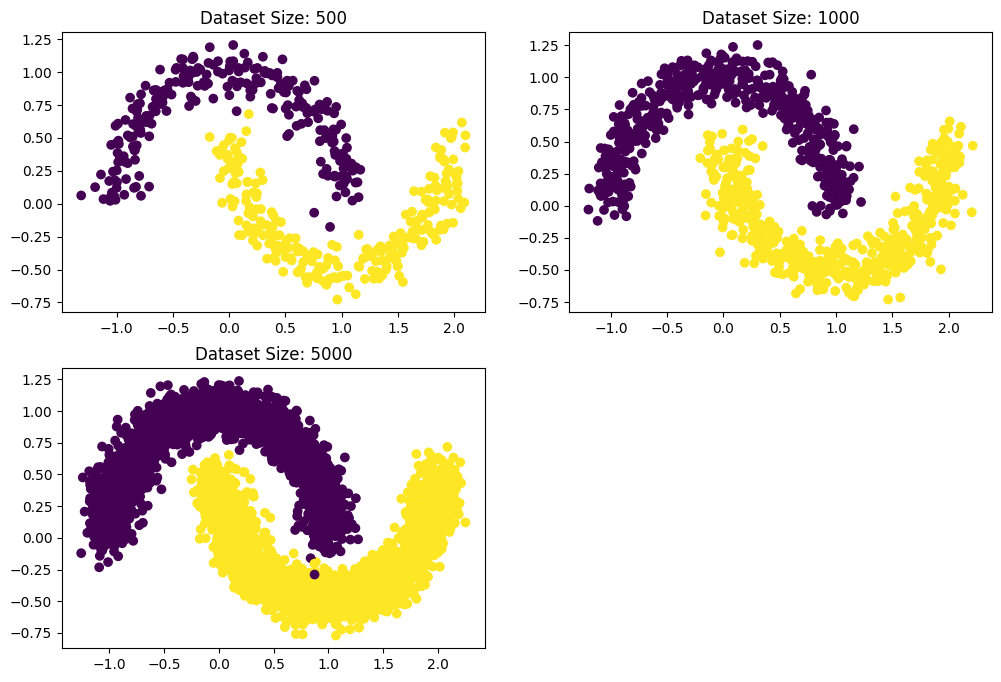

In [ ]:
dataset_sizes = [ 500, 1000, 5000]

# Generate datasets of varying sizes
train_datasets = {}
val_datasets = {}
datasets = {}

for size in dataset_sizes:
    X, y = make_moons(n_samples=size, noise=0.1)
    datasets[size] = {'X': X, 'y': y}
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)# 70:30 test:train
    train_datasets[size] = {'X': torch.FloatTensor(X_train), 'y': y_train}
    val_datasets[size] = {'X': torch.FloatTensor(X_test), 'y': y_test}

# Visualize the training datasets
plt.figure(figsize=(12, 8))

for i, size in enumerate(dataset_sizes, 1):
    plt.subplot(2, 2, i)
    plt.scatter(datasets[size]['X'][:, 0], datasets[size]['X'][:, 1], c=datasets[size]['y'])
    plt.title(f'Dataset Size: {size}')

plt.show()

## Some test runs to find out hyperparameters

<div style="color: green; font-weight:
bold">Comment:</div>

* It would have been better if we had a heading mentioning what are we doing in the next block of codes. (Although we did summarise our test runs thoroughly after these block of codes, but still it would have been way more good.

<div style="color: green; font-weight:
bold">Comment:</div> Checking the effect of bandwidth keeping the mmd_weight and number of epochs fixed (100)


Training and Visualizing for Bandwidth Set 1: [0.1, 0.2, 0.4]
Epoch [20/100], Recon Loss: 0.0223, MMD sqd Loss: 0.2535
Epoch [40/100], Recon Loss: 0.0012, MMD sqd Loss: 0.2328
Epoch [60/100], Recon Loss: 0.0016, MMD sqd Loss: 0.2325
Epoch [80/100], Recon Loss: 0.0011, MMD sqd Loss: 0.2172
Epoch [100/100], Recon Loss: 0.0010, MMD sqd Loss: 0.2277


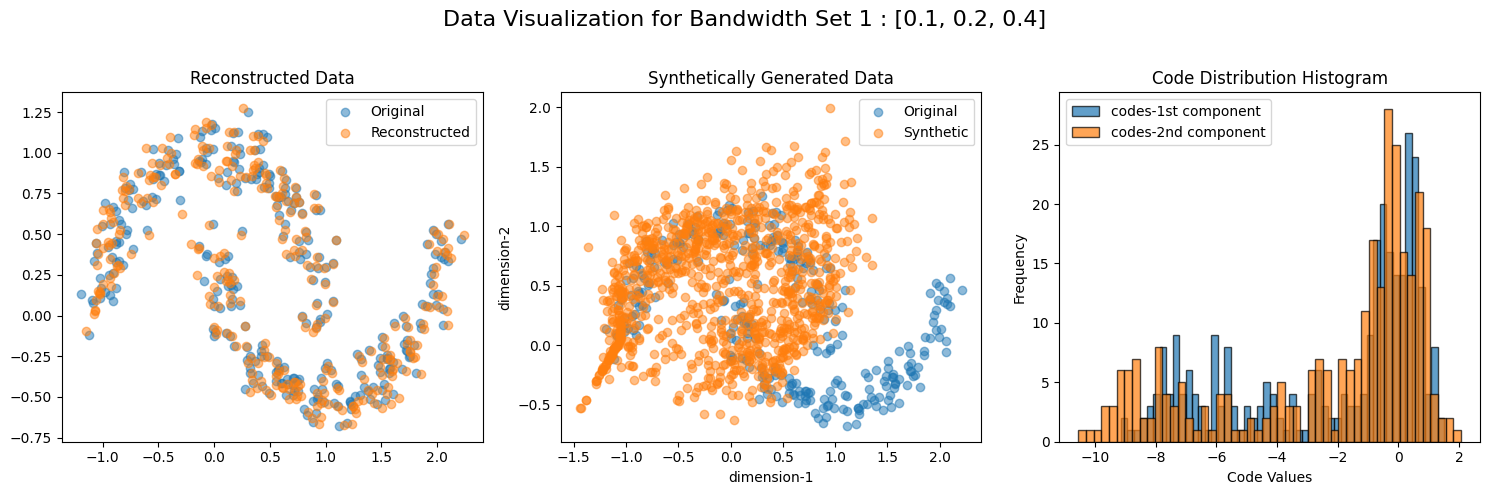


Training and Visualizing for Bandwidth Set 2: [0.1, 0.2, 0.4, 0.6]
Epoch [20/100], Recon Loss: 0.0031, MMD sqd Loss: 0.3519
Epoch [40/100], Recon Loss: 0.0010, MMD sqd Loss: 0.3169
Epoch [60/100], Recon Loss: 0.0012, MMD sqd Loss: 0.2830
Epoch [80/100], Recon Loss: 0.0010, MMD sqd Loss: 0.2887
Epoch [100/100], Recon Loss: 0.0020, MMD sqd Loss: 0.2894


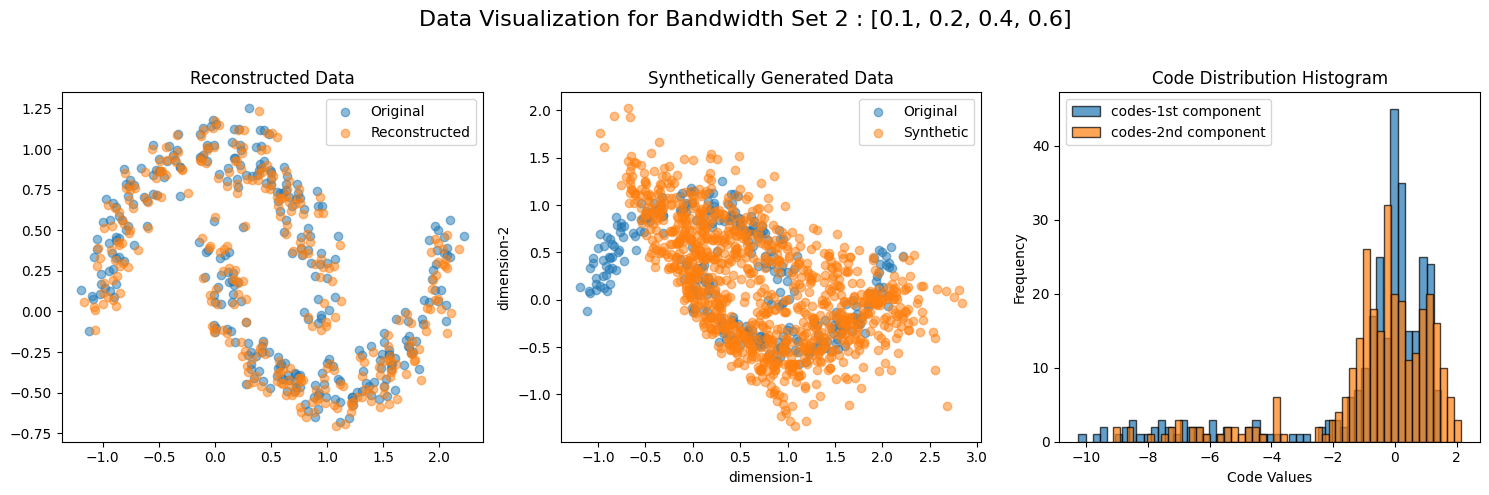


Training and Visualizing for Bandwidth Set 3: [0.1, 0.2, 0.4, 0.6, 0.8]
Epoch [20/100], Recon Loss: 0.0454, MMD sqd Loss: 0.6142
Epoch [40/100], Recon Loss: 0.0389, MMD sqd Loss: 0.5400
Epoch [60/100], Recon Loss: 0.0064, MMD sqd Loss: 0.4197
Epoch [80/100], Recon Loss: 0.0035, MMD sqd Loss: 0.3728
Epoch [100/100], Recon Loss: 0.0037, MMD sqd Loss: 0.3711


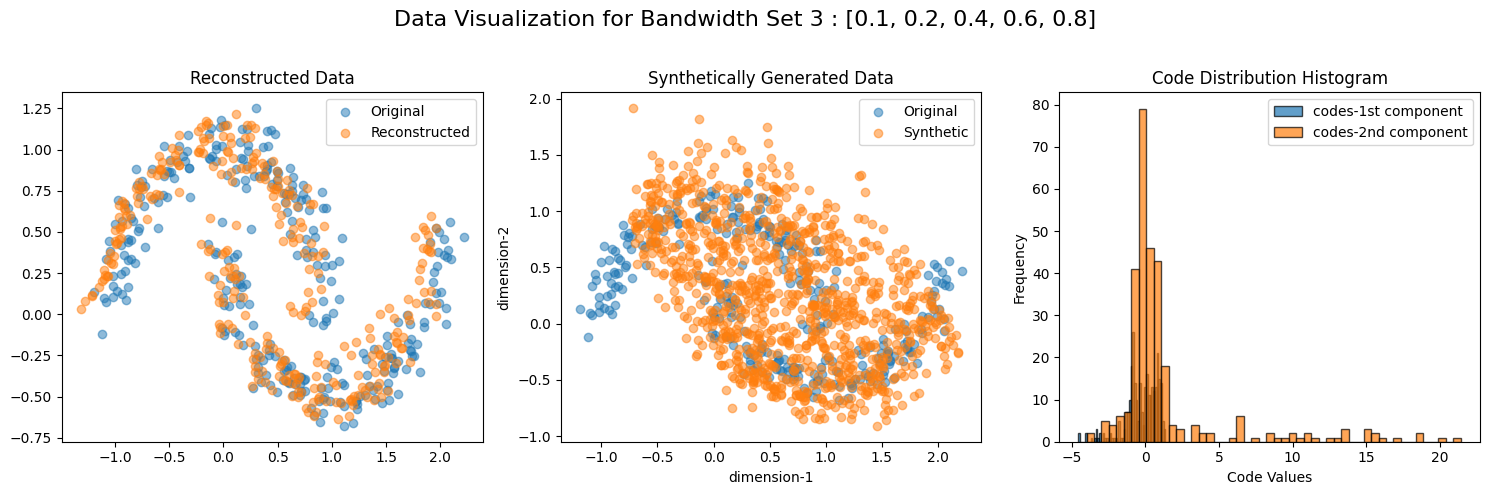


Training and Visualizing for Bandwidth Set 4: [0.1, 0.2, 0.4, 0.6, 0.8, 1.6]
Epoch [20/100], Recon Loss: 0.0188, MMD sqd Loss: 0.6644
Epoch [40/100], Recon Loss: 0.0033, MMD sqd Loss: 0.4593
Epoch [60/100], Recon Loss: 0.0019, MMD sqd Loss: 0.4653
Epoch [80/100], Recon Loss: 0.0021, MMD sqd Loss: 0.4085
Epoch [100/100], Recon Loss: 0.0014, MMD sqd Loss: 0.4370


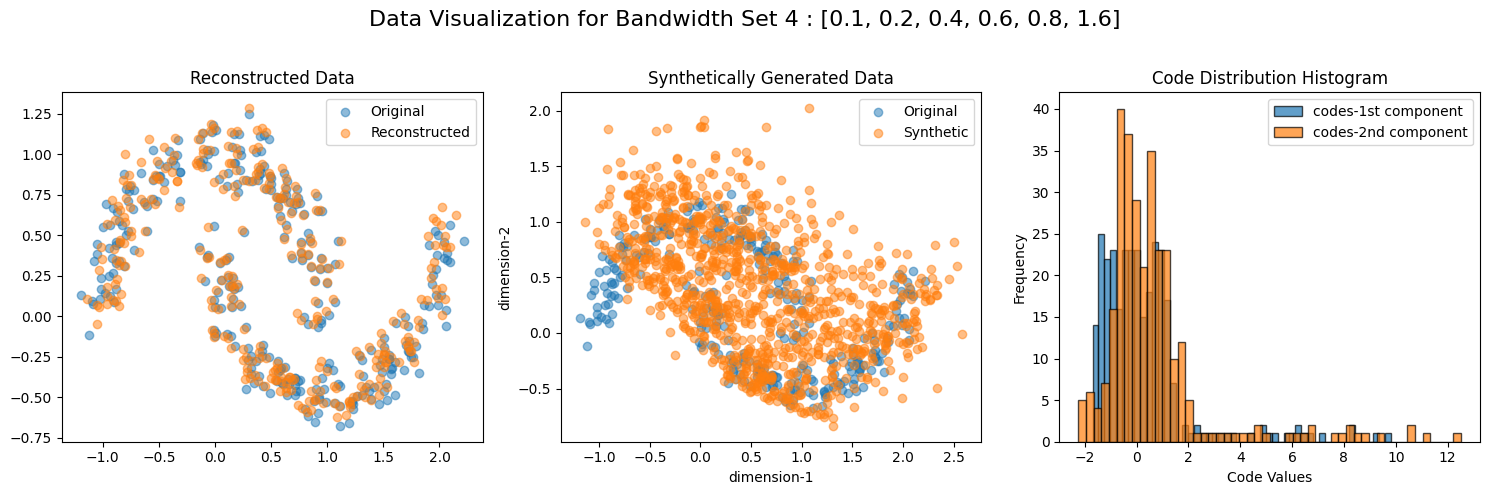

In [ ]:
# Function to train and visualize for different bandwidth sets
def train_and_visualize_for_bandwidth_sets(train_datasets, val_datasets,
                                           bandwidth_sets, mmd_weight=0.15, num_epochs=10):
    for i, bandwidth_set in enumerate(bandwidth_sets):
        # Reset autoencoder model
        model = Autoencoder(input_size=2, bottleneck_size=2, hidden_size=32, layers=3)
        print(f"\nTraining and Visualizing for Bandwidth Set {i + 1}: {bandwidth_set}")
        _, _ = train_mmd_autoencoder(model, train_datasets, val_datasets,
                                     dataset_size=1000, num_epochs=num_epochs,
                                     batch_size=32, learning_rate=0.001,
                                     mmd_weight=mmd_weight, bandwidths=bandwidth_set,
                                     kernel_fn=squared_exponentials_kernel,wanna_print_loss=True)

        # Get the data loader for the validation set
        val_loader = torch.utils.data.DataLoader(val_datasets[1000]['X'], batch_size=32, shuffle=True)

        # Visualize reconstructed data, synthetically generated data, and individual components for the current bandwidth set
        plt.figure(figsize=(15, 5))
        plt.suptitle(f'Data Visualization for Bandwidth Set {i + 1} : {bandwidth_set}', fontsize=16)

        # Subplot 1: Reconstructed Data
        plt.subplot(1, 3, 1)
        visualize_reconstructed_data(model, val_datasets[1000]['X'])
        plt.title('Reconstructed Data')

        # Subplot 2: Synthetically Generated Data
        plt.subplot(1, 3, 2)
        synthetic_data = generate_synthetic_data(model, num_samples=1000)
        visualize_synthetic_data(val_datasets[1000]['X'], synthetic_data)
        plt.title('Synthetically Generated Data')

        # Subplot 3: Visualize Individual Components
        plt.subplot(1, 3, 3)
        visualize_code_distribution_histogram_indiv_component(model, val_loader)

        plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to prevent overlapping subplots
        plt.show()


# Set the fixed mmd_weight
fixed_mmd_weight = 0.15

# Define different bandwidth sets
bandwidth_sets = [[0.1, 0.2, 0.4], [0.1, 0.2, 0.4, 0.6], [0.1, 0.2, 0.4, 0.6, 0.8], [0.1, 0.2, 0.4, 0.6, 0.8, 1.6]]

# Train and visualize for different bandwidth sets
train_and_visualize_for_bandwidth_sets(train_datasets, val_datasets,
                                       bandwidth_sets, mmd_weight=fixed_mmd_weight, num_epochs=100)


<div style="color: green; font-weight:
bold">Comment:</div> checking the effect of number of epochs, keeping the bandwidth and the mmd weight fixed!

bandwidth fixed:
[0.1, 0.2, 0.4]

Training and Visualizing for 100 Epochs
Epoch [20/100], Recon Loss: 0.0396, MMD sqd Loss: 0.2989
Epoch [40/100], Recon Loss: 0.0034, MMD sqd Loss: 0.2536
Epoch [60/100], Recon Loss: 0.0016, MMD sqd Loss: 0.2349
Epoch [80/100], Recon Loss: 0.0017, MMD sqd Loss: 0.2217
Epoch [100/100], Recon Loss: 0.0011, MMD sqd Loss: 0.2254


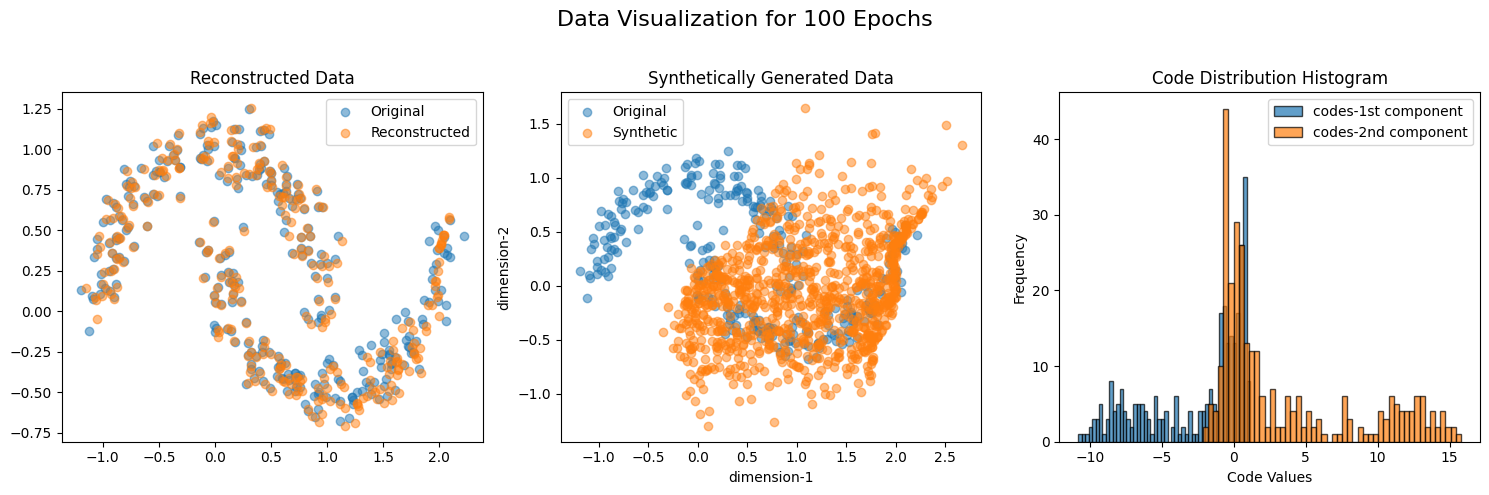


Training and Visualizing for 200 Epochs
Epoch [20/200], Recon Loss: 0.0023, MMD sqd Loss: 0.2613
Epoch [40/200], Recon Loss: 0.0009, MMD sqd Loss: 0.2491
Epoch [60/200], Recon Loss: 0.0009, MMD sqd Loss: 0.2329
Epoch [80/200], Recon Loss: 0.0017, MMD sqd Loss: 0.2303
Epoch [100/200], Recon Loss: 0.0014, MMD sqd Loss: 0.2193
Epoch [120/200], Recon Loss: 0.0012, MMD sqd Loss: 0.2186
Epoch [140/200], Recon Loss: 0.0010, MMD sqd Loss: 0.2092
Epoch [160/200], Recon Loss: 0.0008, MMD sqd Loss: 0.2108
Epoch [180/200], Recon Loss: 0.0008, MMD sqd Loss: 0.2100
Epoch [200/200], Recon Loss: 0.0012, MMD sqd Loss: 0.2058


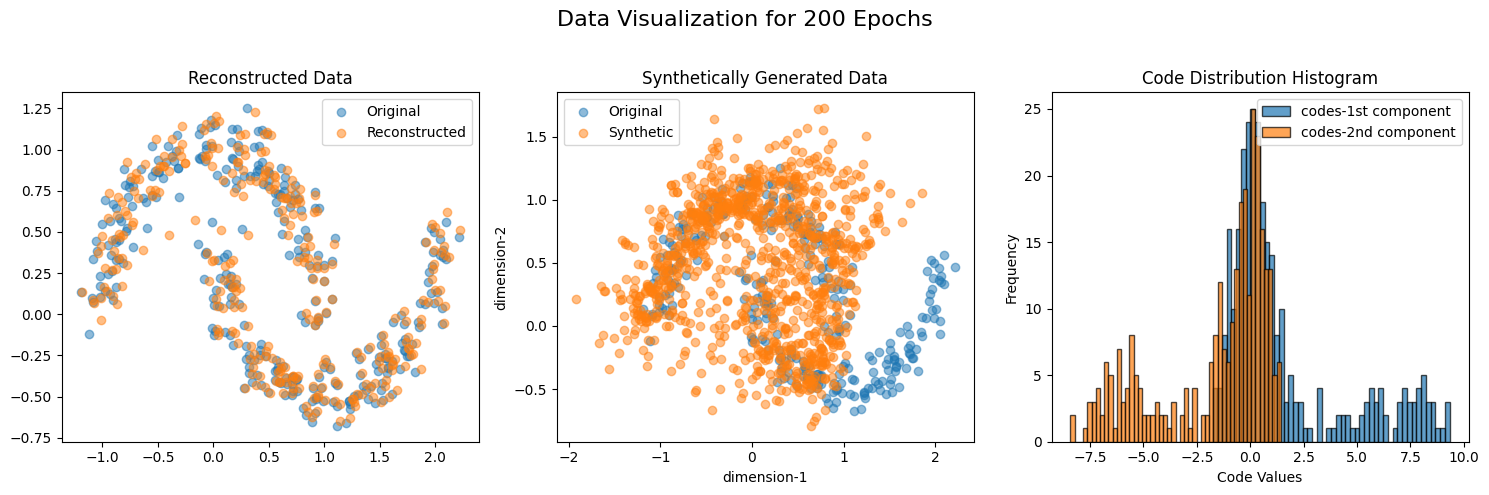


Training and Visualizing for 300 Epochs
Epoch [20/300], Recon Loss: 0.0013, MMD sqd Loss: 0.2630
Epoch [40/300], Recon Loss: 0.0005, MMD sqd Loss: 0.2279
Epoch [60/300], Recon Loss: 0.0005, MMD sqd Loss: 0.2285
Epoch [80/300], Recon Loss: 0.0005, MMD sqd Loss: 0.2201
Epoch [100/300], Recon Loss: 0.0008, MMD sqd Loss: 0.2164
Epoch [120/300], Recon Loss: 0.0005, MMD sqd Loss: 0.2034
Epoch [140/300], Recon Loss: 0.0006, MMD sqd Loss: 0.2126
Epoch [160/300], Recon Loss: 0.0004, MMD sqd Loss: 0.2054
Epoch [180/300], Recon Loss: 0.0005, MMD sqd Loss: 0.2108
Epoch [200/300], Recon Loss: 0.0005, MMD sqd Loss: 0.2075
Epoch [220/300], Recon Loss: 0.0007, MMD sqd Loss: 0.2077
Epoch [240/300], Recon Loss: 0.0004, MMD sqd Loss: 0.2087
Epoch [260/300], Recon Loss: 0.0007, MMD sqd Loss: 0.2023
Epoch [280/300], Recon Loss: 0.0004, MMD sqd Loss: 0.2033
Epoch [300/300], Recon Loss: 0.0005, MMD sqd Loss: 0.2017


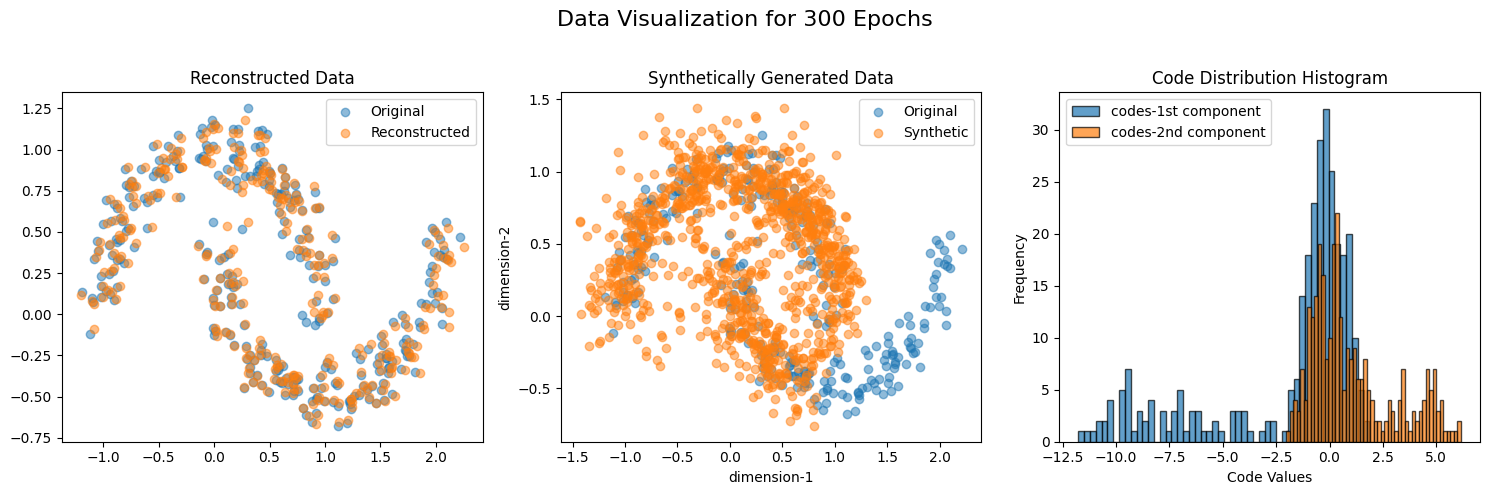


Training and Visualizing for 400 Epochs
Epoch [20/400], Recon Loss: 0.0596, MMD sqd Loss: 0.2999
Epoch [40/400], Recon Loss: 0.0013, MMD sqd Loss: 0.2247
Epoch [60/400], Recon Loss: 0.0006, MMD sqd Loss: 0.2176
Epoch [80/400], Recon Loss: 0.0007, MMD sqd Loss: 0.2265
Epoch [100/400], Recon Loss: 0.0011, MMD sqd Loss: 0.2097
Epoch [120/400], Recon Loss: 0.0007, MMD sqd Loss: 0.2082
Epoch [140/400], Recon Loss: 0.0007, MMD sqd Loss: 0.2090
Epoch [160/400], Recon Loss: 0.0006, MMD sqd Loss: 0.2097
Epoch [180/400], Recon Loss: 0.0005, MMD sqd Loss: 0.2231
Epoch [200/400], Recon Loss: 0.0004, MMD sqd Loss: 0.2069
Epoch [220/400], Recon Loss: 0.0008, MMD sqd Loss: 0.2102
Epoch [240/400], Recon Loss: 0.0009, MMD sqd Loss: 0.2034
Epoch [260/400], Recon Loss: 0.0008, MMD sqd Loss: 0.1993
Epoch [280/400], Recon Loss: 0.0011, MMD sqd Loss: 0.2069
Epoch [300/400], Recon Loss: 0.0004, MMD sqd Loss: 0.2059
Epoch [320/400], Recon Loss: 0.0005, MMD sqd Loss: 0.2087
Epoch [340/400], Recon Loss: 0.0006

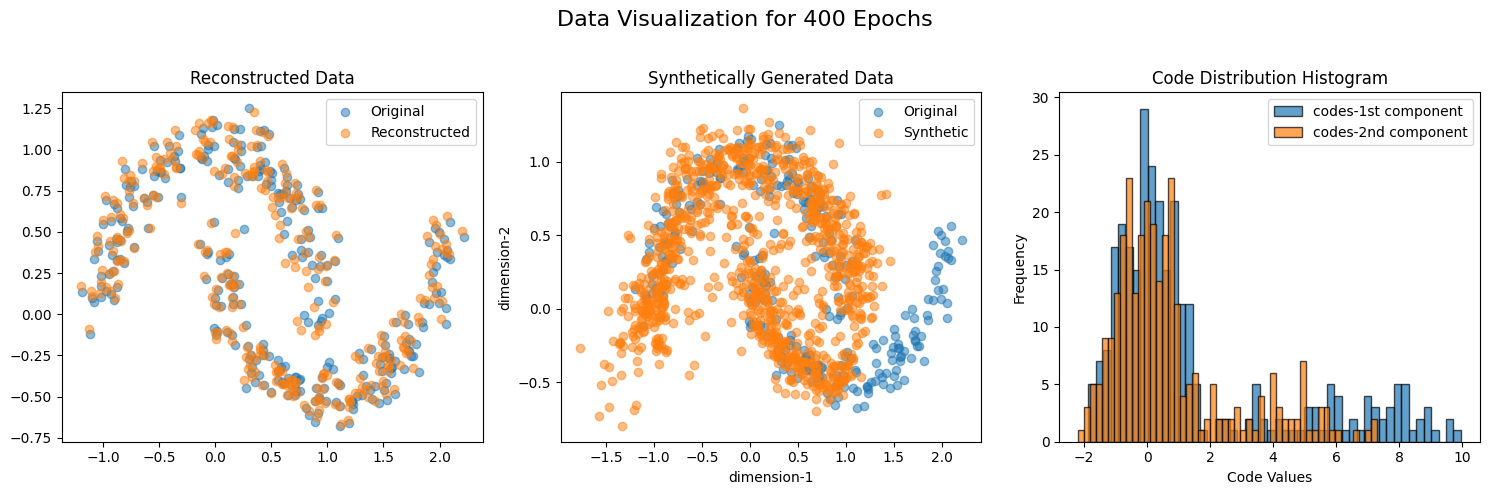


Training and Visualizing for 500 Epochs
Epoch [20/500], Recon Loss: 0.0038, MMD sqd Loss: 0.2727
Epoch [40/500], Recon Loss: 0.0005, MMD sqd Loss: 0.2458
Epoch [60/500], Recon Loss: 0.0009, MMD sqd Loss: 0.2390
Epoch [80/500], Recon Loss: 0.0005, MMD sqd Loss: 0.2324
Epoch [100/500], Recon Loss: 0.0011, MMD sqd Loss: 0.2279
Epoch [120/500], Recon Loss: 0.0004, MMD sqd Loss: 0.2288
Epoch [140/500], Recon Loss: 0.0005, MMD sqd Loss: 0.2167
Epoch [160/500], Recon Loss: 0.0004, MMD sqd Loss: 0.2105
Epoch [180/500], Recon Loss: 0.0006, MMD sqd Loss: 0.2154
Epoch [200/500], Recon Loss: 0.0008, MMD sqd Loss: 0.2068
Epoch [220/500], Recon Loss: 0.0007, MMD sqd Loss: 0.2087
Epoch [240/500], Recon Loss: 0.0010, MMD sqd Loss: 0.2123
Epoch [260/500], Recon Loss: 0.0006, MMD sqd Loss: 0.2068
Epoch [280/500], Recon Loss: 0.0004, MMD sqd Loss: 0.2091
Epoch [300/500], Recon Loss: 0.0005, MMD sqd Loss: 0.2097
Epoch [320/500], Recon Loss: 0.0004, MMD sqd Loss: 0.2101
Epoch [340/500], Recon Loss: 0.0009

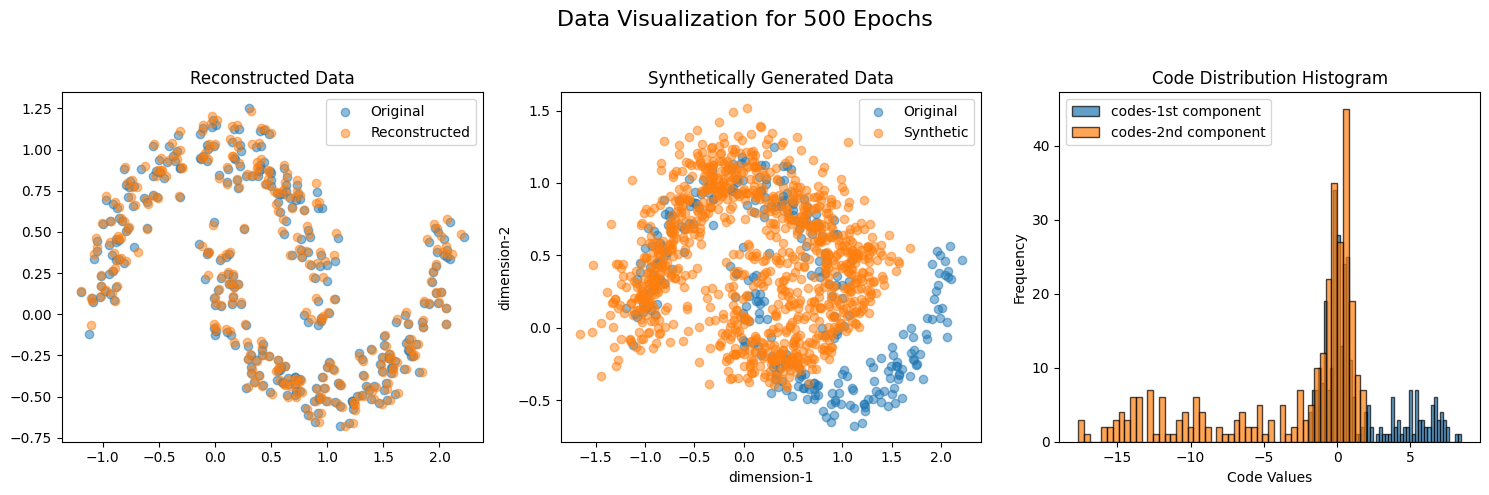

In [ ]:
# Function to train and visualize for different numbers of epochs
def train_and_visualize_for_epochs(train_datasets, val_datasets,
                                   fixed_bandwidth_set, mmd_weight=0.15, epochs_list=[100, 200, 300, 400, 500]):
    for i, num_epochs in enumerate(epochs_list):
        # Reset autoencoder model
        model = Autoencoder(input_size=2, bottleneck_size=2, hidden_size=32, layers=3)
        print(f"\nTraining and Visualizing for {num_epochs} Epochs")
        _, _ = train_mmd_autoencoder(model, train_datasets, val_datasets,
                                     dataset_size=1000, num_epochs=num_epochs,
                                     batch_size=32, learning_rate=0.001,
                                     mmd_weight=mmd_weight, bandwidths=fixed_bandwidth_set,
                                     kernel_fn=squared_exponentials_kernel, wanna_print_loss=True)

        # Get the data loader for the validation set
        val_loader = torch.utils.data.DataLoader(val_datasets[1000]['X'], batch_size=32, shuffle=True)

        # Visualize reconstructed data, synthetically generated data, and individual components for the current number of epochs
        plt.figure(figsize=(15, 5))
        plt.suptitle(f'Data Visualization for fixed bandwidth = {fixed_bandwidth_set} and  {num_epochs} Epochs', fontsize=16)

        # Subplot 1: Reconstructed Data
        plt.subplot(1, 3, 1)
        visualize_reconstructed_data(model, val_datasets[1000]['X'])
        plt.title('Reconstructed Data')

        # Subplot 2: Synthetically Generated Data
        plt.subplot(1, 3, 2)
        synthetic_data = generate_synthetic_data(model, num_samples=1000)
        visualize_synthetic_data(val_datasets[1000]['X'], synthetic_data)
        plt.title('Synthetically Generated Data')

        # Subplot 3: Visualize Individual Components
        plt.subplot(1, 3, 3)
        visualize_code_distribution_histogram_indiv_component(model, val_loader)

        plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to prevent overlapping subplots
        plt.show()

# Set the fixed bandwidth
fixed_bandwidth_set = [0.1, 0.2, 0.4]

# Train and visualize for different numbers of epochs
print("bandwidth fixed:");print(fixed_bandwidth_set)
train_and_visualize_for_epochs(train_datasets, val_datasets,
                               fixed_bandwidth_set, mmd_weight=0.15, epochs_list=[100, 200, 300, 400, 500])


<div style="color: green; font-weight:
bold">Comment:</div> Comparing the effect of mmd_weight_values keeping the number of bandwidths and the number of epochs fixed!


Training and Visualizing for MMD Weight 1: 0.1
Epoch [20/400], Recon Loss: 0.0009, MMD sqd Loss: 0.4430
Epoch [40/400], Recon Loss: 0.0009, MMD sqd Loss: 0.4387
Epoch [60/400], Recon Loss: 0.0011, MMD sqd Loss: 0.4286
Epoch [80/400], Recon Loss: 0.0010, MMD sqd Loss: 0.3909
Epoch [100/400], Recon Loss: 0.0005, MMD sqd Loss: 0.4053
Epoch [120/400], Recon Loss: 0.0010, MMD sqd Loss: 0.3976
Epoch [140/400], Recon Loss: 0.0009, MMD sqd Loss: 0.4115
Epoch [160/400], Recon Loss: 0.0010, MMD sqd Loss: 0.4317
Epoch [180/400], Recon Loss: 0.0007, MMD sqd Loss: 0.4007
Epoch [200/400], Recon Loss: 0.0004, MMD sqd Loss: 0.4085
Epoch [220/400], Recon Loss: 0.0014, MMD sqd Loss: 0.4240
Epoch [240/400], Recon Loss: 0.0007, MMD sqd Loss: 0.3878
Epoch [260/400], Recon Loss: 0.0009, MMD sqd Loss: 0.3644
Epoch [280/400], Recon Loss: 0.0008, MMD sqd Loss: 0.3953
Epoch [300/400], Recon Loss: 0.0006, MMD sqd Loss: 0.3682
Epoch [320/400], Recon Loss: 0.0009, MMD sqd Loss: 0.3839
Epoch [340/400], Recon Loss:

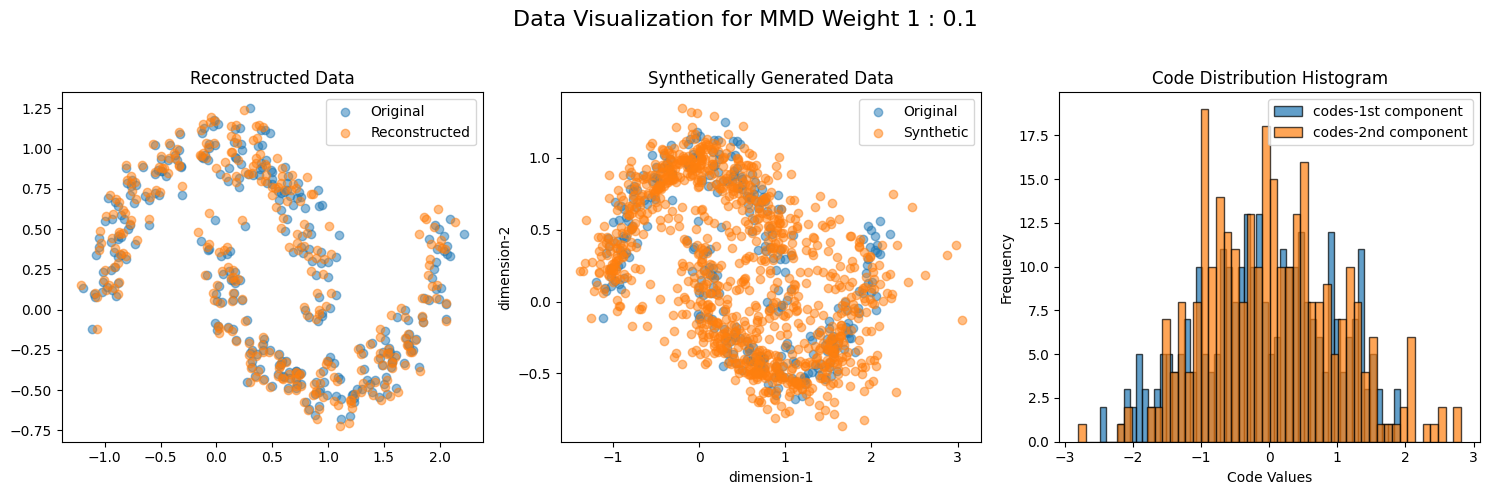


Training and Visualizing for MMD Weight 2: 0.2
Epoch [20/400], Recon Loss: 0.0038, MMD sqd Loss: 0.5183
Epoch [40/400], Recon Loss: 0.0022, MMD sqd Loss: 0.4380
Epoch [60/400], Recon Loss: 0.0015, MMD sqd Loss: 0.4149
Epoch [80/400], Recon Loss: 0.0011, MMD sqd Loss: 0.4567
Epoch [100/400], Recon Loss: 0.0015, MMD sqd Loss: 0.4102
Epoch [120/400], Recon Loss: 0.0026, MMD sqd Loss: 0.4209
Epoch [140/400], Recon Loss: 0.0010, MMD sqd Loss: 0.3764
Epoch [160/400], Recon Loss: 0.0023, MMD sqd Loss: 0.4003
Epoch [180/400], Recon Loss: 0.0012, MMD sqd Loss: 0.4195
Epoch [200/400], Recon Loss: 0.0029, MMD sqd Loss: 0.3980
Epoch [220/400], Recon Loss: 0.0017, MMD sqd Loss: 0.3910
Epoch [240/400], Recon Loss: 0.0015, MMD sqd Loss: 0.4020
Epoch [260/400], Recon Loss: 0.0012, MMD sqd Loss: 0.3865
Epoch [280/400], Recon Loss: 0.0013, MMD sqd Loss: 0.3722
Epoch [300/400], Recon Loss: 0.0017, MMD sqd Loss: 0.4097
Epoch [320/400], Recon Loss: 0.0009, MMD sqd Loss: 0.4223
Epoch [340/400], Recon Loss:

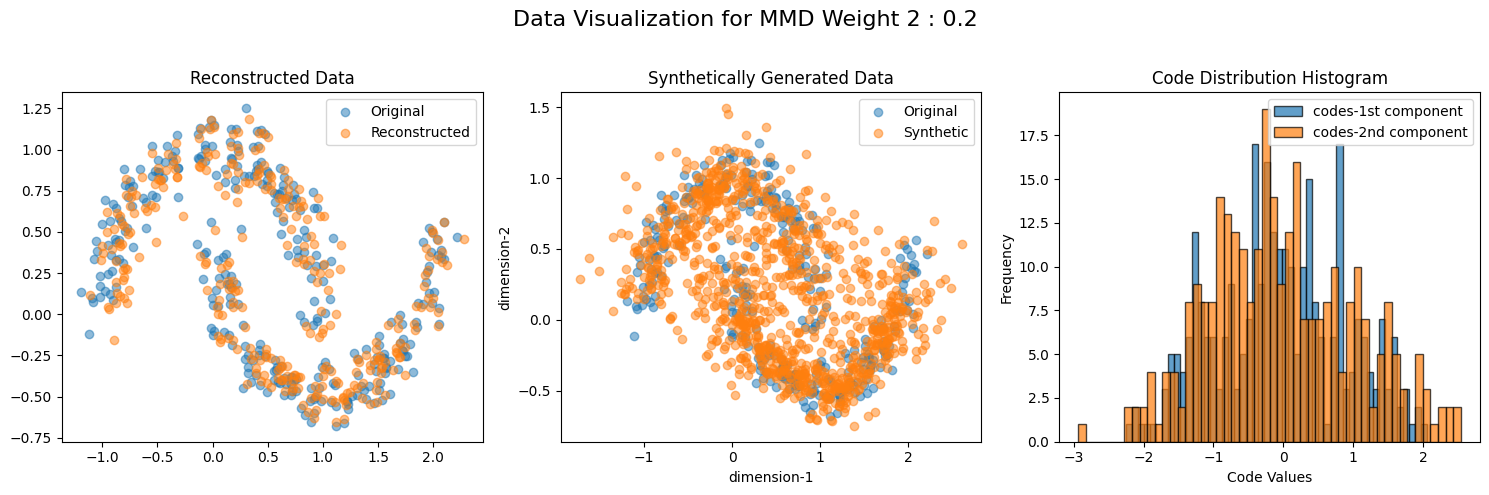


Training and Visualizing for MMD Weight 3: 0.5
Epoch [20/400], Recon Loss: 0.0064, MMD sqd Loss: 0.4709
Epoch [40/400], Recon Loss: 0.0054, MMD sqd Loss: 0.4414
Epoch [60/400], Recon Loss: 0.0018, MMD sqd Loss: 0.4417
Epoch [80/400], Recon Loss: 0.0020, MMD sqd Loss: 0.3976
Epoch [100/400], Recon Loss: 0.0026, MMD sqd Loss: 0.4214
Epoch [120/400], Recon Loss: 0.0020, MMD sqd Loss: 0.4150
Epoch [140/400], Recon Loss: 0.0015, MMD sqd Loss: 0.4129
Epoch [160/400], Recon Loss: 0.0020, MMD sqd Loss: 0.4114
Epoch [180/400], Recon Loss: 0.0019, MMD sqd Loss: 0.3861
Epoch [200/400], Recon Loss: 0.0013, MMD sqd Loss: 0.4114
Epoch [220/400], Recon Loss: 0.0022, MMD sqd Loss: 0.3902
Epoch [240/400], Recon Loss: 0.0023, MMD sqd Loss: 0.4027
Epoch [260/400], Recon Loss: 0.0018, MMD sqd Loss: 0.3976
Epoch [280/400], Recon Loss: 0.0025, MMD sqd Loss: 0.3964
Epoch [300/400], Recon Loss: 0.0045, MMD sqd Loss: 0.4379
Epoch [320/400], Recon Loss: 0.0027, MMD sqd Loss: 0.3897
Epoch [340/400], Recon Loss:

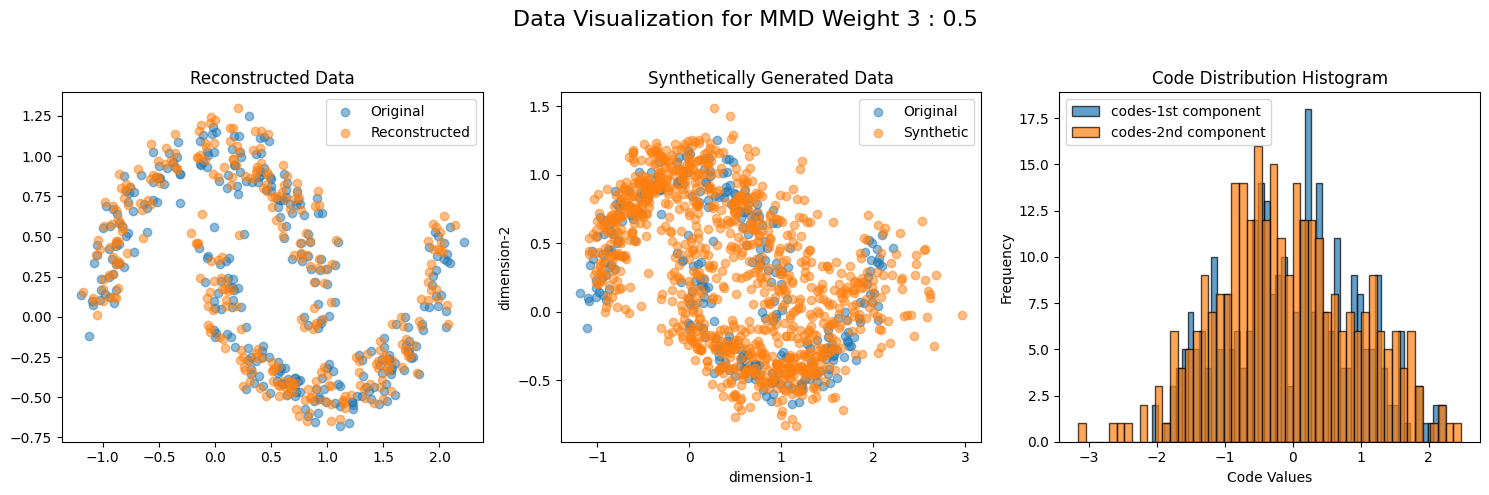


Training and Visualizing for MMD Weight 4: 1.0
Epoch [20/400], Recon Loss: 0.0062, MMD sqd Loss: 0.4484
Epoch [40/400], Recon Loss: 0.0061, MMD sqd Loss: 0.4344
Epoch [60/400], Recon Loss: 0.0065, MMD sqd Loss: 0.4403
Epoch [80/400], Recon Loss: 0.0062, MMD sqd Loss: 0.4351
Epoch [100/400], Recon Loss: 0.0057, MMD sqd Loss: 0.4181
Epoch [120/400], Recon Loss: 0.0047, MMD sqd Loss: 0.4236
Epoch [140/400], Recon Loss: 0.0089, MMD sqd Loss: 0.4301
Epoch [160/400], Recon Loss: 0.0042, MMD sqd Loss: 0.4056
Epoch [180/400], Recon Loss: 0.0041, MMD sqd Loss: 0.3946
Epoch [200/400], Recon Loss: 0.0088, MMD sqd Loss: 0.4290
Epoch [220/400], Recon Loss: 0.0090, MMD sqd Loss: 0.4112
Epoch [240/400], Recon Loss: 0.0037, MMD sqd Loss: 0.4410
Epoch [260/400], Recon Loss: 0.0027, MMD sqd Loss: 0.3715
Epoch [280/400], Recon Loss: 0.0052, MMD sqd Loss: 0.4395
Epoch [300/400], Recon Loss: 0.0039, MMD sqd Loss: 0.3856
Epoch [320/400], Recon Loss: 0.0062, MMD sqd Loss: 0.3965
Epoch [340/400], Recon Loss:

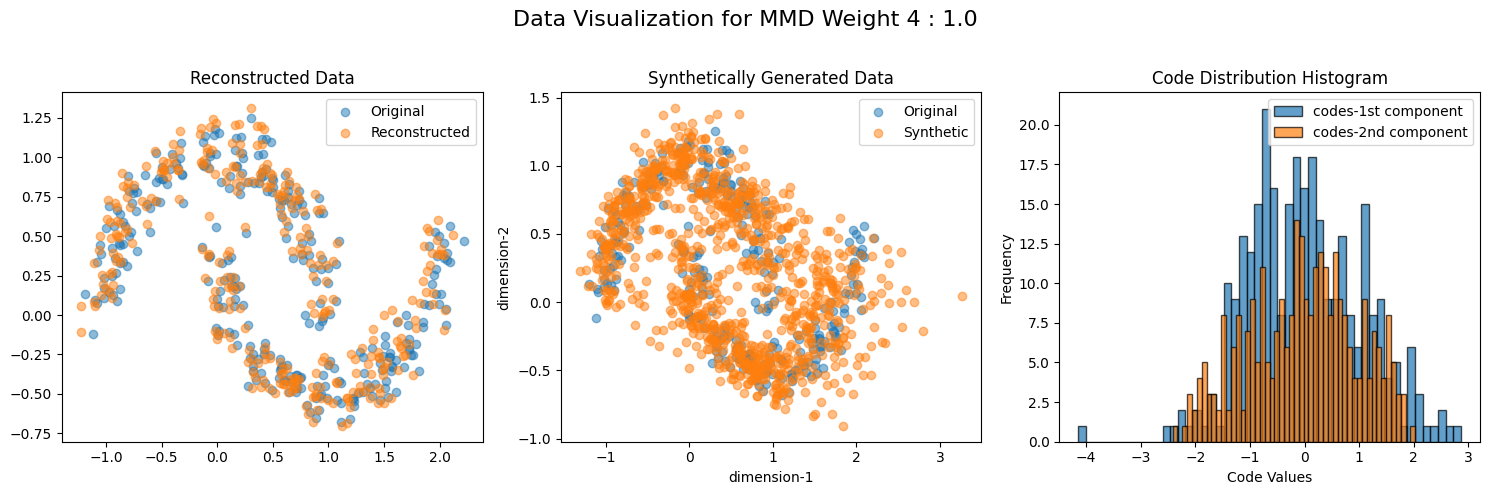


Training and Visualizing for MMD Weight 5: 2.0
Epoch [20/400], Recon Loss: 0.0077, MMD sqd Loss: 0.4410
Epoch [40/400], Recon Loss: 0.0118, MMD sqd Loss: 0.4877
Epoch [60/400], Recon Loss: 0.0088, MMD sqd Loss: 0.4084
Epoch [80/400], Recon Loss: 0.0061, MMD sqd Loss: 0.4245
Epoch [100/400], Recon Loss: 0.0064, MMD sqd Loss: 0.3892
Epoch [120/400], Recon Loss: 0.0087, MMD sqd Loss: 0.4200
Epoch [140/400], Recon Loss: 0.0119, MMD sqd Loss: 0.4267
Epoch [160/400], Recon Loss: 0.0029, MMD sqd Loss: 0.3853
Epoch [180/400], Recon Loss: 0.0162, MMD sqd Loss: 0.4458
Epoch [200/400], Recon Loss: 0.0102, MMD sqd Loss: 0.4062
Epoch [220/400], Recon Loss: 0.0034, MMD sqd Loss: 0.4036
Epoch [240/400], Recon Loss: 0.0049, MMD sqd Loss: 0.4223
Epoch [260/400], Recon Loss: 0.0063, MMD sqd Loss: 0.4107
Epoch [280/400], Recon Loss: 0.0021, MMD sqd Loss: 0.4154
Epoch [300/400], Recon Loss: 0.0114, MMD sqd Loss: 0.3892
Epoch [320/400], Recon Loss: 0.0051, MMD sqd Loss: 0.3867
Epoch [340/400], Recon Loss:

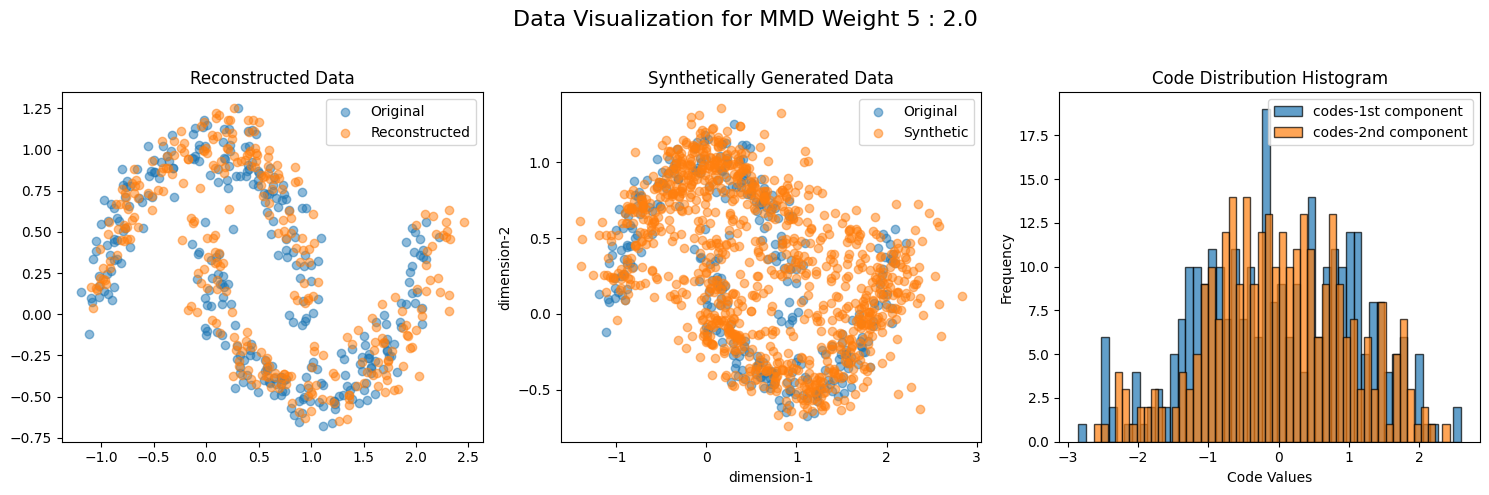

In [ ]:
# Function to train and visualize for different mmd_weight values
def train_and_visualize_for_mmd_weights(train_datasets, val_datasets,
                                        bandwidths=[0.1, 0.2, 0.4, 0.6, 0.8, 1.6],
                                        num_epochs=400, mmd_weights=[0.1, 0.2, 0.5, 1.0, 2.0]):
    for i, mmd_weight in enumerate(mmd_weights):
         # Reset autoencoder model
        model = Autoencoder(input_size=2, bottleneck_size=2, hidden_size=32, layers=3)
        print(f"\nTraining and Visualizing for MMD Weight {i + 1}: {mmd_weight}")
        _, _ = train_mmd_autoencoder(model, train_datasets, val_datasets,
                                     dataset_size=1000, num_epochs=num_epochs,
                                     batch_size=32, learning_rate=0.001,
                                     mmd_weight=mmd_weight, bandwidths=bandwidths,
                                     kernel_fn=squared_exponentials_kernel, wanna_print_loss=True)

        # Get the data loader for the validation set
        val_loader = torch.utils.data.DataLoader(val_datasets[1000]['X'], batch_size=32, shuffle=True)

        # Visualize reconstructed data, synthetically generated data, and individual components for the current mmd_weight
        plt.figure(figsize=(15, 5))
        plt.suptitle(f'Data Visualization for MMD Weight {i + 1} : {mmd_weight}', fontsize=16)

        # Subplot 1: Reconstructed Data
        plt.subplot(1, 3, 1)
        visualize_reconstructed_data(model, val_datasets[1000]['X'])
        plt.title('Reconstructed Data')

        # Subplot 2: Synthetically Generated Data
        plt.subplot(1, 3, 2)
        synthetic_data = generate_synthetic_data(model, num_samples=1000)
        visualize_synthetic_data(val_datasets[1000]['X'], synthetic_data)
        plt.title('Synthetically Generated Data')

        # Subplot 3: Visualize Individual Components
        plt.subplot(1, 3, 3)
        visualize_code_distribution_histogram_indiv_component(model, val_loader)

        plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to prevent overlapping subplots
        plt.show()

train_and_visualize_for_mmd_weights(train_datasets, val_datasets, num_epochs=400)


### **Summary of some observations we made while figuring out the choice of hyperparameters:**

**Keeping mmd_weight (lambda) fixed (we kept it 0.15):**

1. *Kept number of epoch fixed=100 and changed number of bandwidths (for the kernel function):*

  * Bandwidths considered={[0.1, 0.2, 0.4],[0.1, 0.2, 0.4,0.6],[0.1, 0.2, 0.4,0.6,0.8],[0.1, 0.2, 0.4,0.6,0.8,1.6]}.

  * Found that on increasing the number of bandwidth values, the reconstruction loss increases.
  
  * We also found that the quality (on visual inspection)of synthetically generated points improved as the number of bandwidths for the kernel increased. When lesser number of bandwidths are considered, the synthetically generated data is more clustered either in the region of one of the moons or to a particular region of the dataset. In other words one was not able sample from the region of both the 2 arcs entirely. On increasing the number of epochs, the region covered by synthetically generated dataset sort of smears out and the two arcs (moons) can be seen forming.


  * In the code distribution bar-plot (the one where we have plotted 2 bar plots for 2 components of the codes), we observed that bar plot both the components of the code matrix are not symmetrically centered about the origin for the case when we choose smaller and lesser number of bandwidths (for example: [0.1,0.4,0.4]). The bar plot for both the components for the codes would be more heavily tailed in one of the direction around the origin and quite squeezed/compact in the other direction
  
  On increasing the number of bandwidth values, we observe that that the distribution (bar plot) of the 2 components of codes starts to get more symmetric around the center (i.e. the origin).

2. *Keeping the number and values of bandwidths considered fixed and increasing the number of epochs::*

  * On increasing the number of epochs, the reconstruction loss decresed, something we would expect.
  * We saw improvements in the synthetically data generated with increase in number of epoch (for eg. for the case bandwidth=[0.1,0.2,0.4], for smaller no. of epochs, synthetically data generated was more clustered either in the region of one of the moons or to a particular region of the dataset) whereas on increasing the number of epochs, the region covered by synthetically generated dataset sort of smears out (i.e. not just clustered in the region of one of the moons) and once again the two arcs (moons) can be seen forming.

From these 2 experiements, we found that the a well suited value(s) for bandwidths and number of epochs to be: bandwidth=[0.1,0.2,0.4,0.6,0.8,1.6] and number of epochs=400-500 (on visual inspection, we did not found much difference for epoch in this range).

<div style="color: green; font-weight:
bold">Comment: </div>

* Clearly the resnet architecture is more well suited then simple autoencoder model to address this task.

* For Case 1: Our observation that increasing the number of bandwidths in the kernel function increases the quality of the synthetically generated dataset is indeed consistent with the sample solution.

* For Case 2: Once again, our observation that increasing the number of epochs increases the quality of the synthetically generated data (increase in number of epochs results in 2 arcs that can be seen forming) is consistent with the sample solution.


* Just like sample solution, we decided to choose more number of bandwidht values (for kernel) as well as more number of epochs. However note that the quality of our results is clearly not better than the sample solution. We could have considered more number of bandwidths.

<div style="color: green; font-weight:
bold">Comment: </div>

* Another most important thing that we must have done while figuring out the suitable choice of the hyperparameters is to plot a 2d histogram/code distribution (Although we did it later for the final run of the model) and not simply histograms of 2 components, the way its done in the sample solution! This is because for better cases (choices of the hyperparameters for our problem), the code distribution would have looked more like a normal distribution and for in-approrpiate choices of the hyperparameters, we would have observed either 2 vertival arcs, or maybe something more worse than that. Such a visualisation would have given us a much better idea of whether the choice of our hyperparameters is indeed good or not!

* **Although our observation regrading the 2d histogram distribution of both the components of the code distribution being heavily tailed for bad choices of hyperparameters is also a good observation !!!**


Training and Visualizing for MMD Weight 1: 0.1
Epoch [20/400], Recon Loss: 0.0505, MMD sqd Loss: 0.7739
Epoch [40/400], Recon Loss: 0.0021, MMD sqd Loss: 0.4992
Epoch [60/400], Recon Loss: 0.0012, MMD sqd Loss: 0.4652
Epoch [80/400], Recon Loss: 0.0014, MMD sqd Loss: 0.4558
Epoch [100/400], Recon Loss: 0.0011, MMD sqd Loss: 0.4018
Epoch [120/400], Recon Loss: 0.0012, MMD sqd Loss: 0.4194
Epoch [140/400], Recon Loss: 0.0010, MMD sqd Loss: 0.3952
Epoch [160/400], Recon Loss: 0.0012, MMD sqd Loss: 0.3807
Epoch [180/400], Recon Loss: 0.0011, MMD sqd Loss: 0.4356
Epoch [200/400], Recon Loss: 0.0008, MMD sqd Loss: 0.4092
Epoch [220/400], Recon Loss: 0.0016, MMD sqd Loss: 0.4423
Epoch [240/400], Recon Loss: 0.0006, MMD sqd Loss: 0.3697
Epoch [260/400], Recon Loss: 0.0009, MMD sqd Loss: 0.3956
Epoch [280/400], Recon Loss: 0.0006, MMD sqd Loss: 0.4006
Epoch [300/400], Recon Loss: 0.0006, MMD sqd Loss: 0.3998
Epoch [320/400], Recon Loss: 0.0004, MMD sqd Loss: 0.3941
Epoch [340/400], Recon Loss:

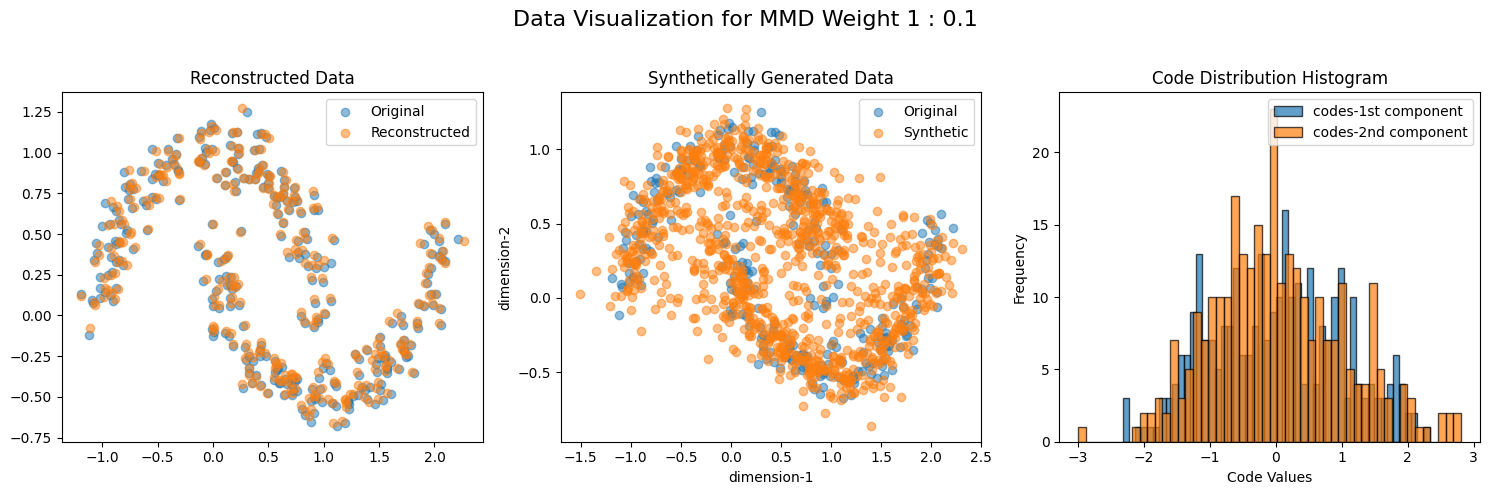


Training and Visualizing for MMD Weight 2: 0.2
Epoch [20/400], Recon Loss: 0.0018, MMD sqd Loss: 0.4599
Epoch [40/400], Recon Loss: 0.0015, MMD sqd Loss: 0.4559
Epoch [60/400], Recon Loss: 0.0015, MMD sqd Loss: 0.4170
Epoch [80/400], Recon Loss: 0.0013, MMD sqd Loss: 0.4086
Epoch [100/400], Recon Loss: 0.0023, MMD sqd Loss: 0.4243
Epoch [120/400], Recon Loss: 0.0009, MMD sqd Loss: 0.4073
Epoch [140/400], Recon Loss: 0.0013, MMD sqd Loss: 0.3891
Epoch [160/400], Recon Loss: 0.0026, MMD sqd Loss: 0.3957
Epoch [180/400], Recon Loss: 0.0015, MMD sqd Loss: 0.3879
Epoch [200/400], Recon Loss: 0.0018, MMD sqd Loss: 0.4219
Epoch [220/400], Recon Loss: 0.0014, MMD sqd Loss: 0.4000
Epoch [240/400], Recon Loss: 0.0017, MMD sqd Loss: 0.3919
Epoch [260/400], Recon Loss: 0.0011, MMD sqd Loss: 0.3948
Epoch [280/400], Recon Loss: 0.0011, MMD sqd Loss: 0.4001
Epoch [300/400], Recon Loss: 0.0018, MMD sqd Loss: 0.3841
Epoch [320/400], Recon Loss: 0.0006, MMD sqd Loss: 0.3948
Epoch [340/400], Recon Loss:

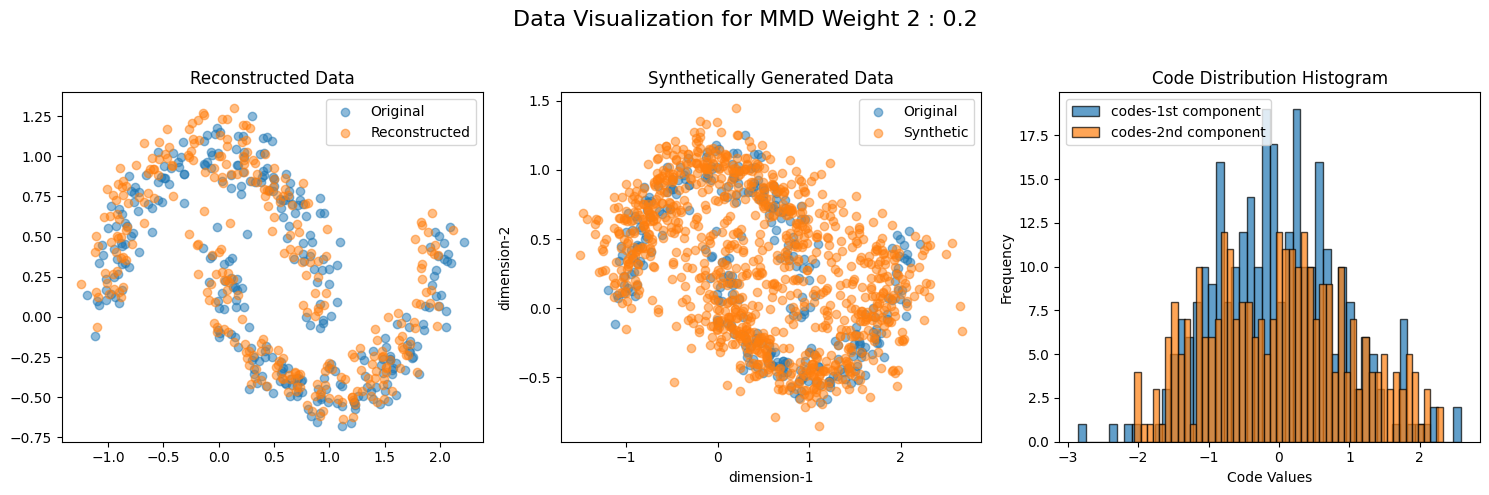


Training and Visualizing for MMD Weight 3: 0.5
Epoch [20/400], Recon Loss: 0.0564, MMD sqd Loss: 0.7882
Epoch [40/400], Recon Loss: 0.0092, MMD sqd Loss: 0.4464
Epoch [60/400], Recon Loss: 0.0033, MMD sqd Loss: 0.4181
Epoch [80/400], Recon Loss: 0.0058, MMD sqd Loss: 0.4215
Epoch [100/400], Recon Loss: 0.0067, MMD sqd Loss: 0.4032
Epoch [120/400], Recon Loss: 0.0049, MMD sqd Loss: 0.4020
Epoch [140/400], Recon Loss: 0.0033, MMD sqd Loss: 0.3782
Epoch [160/400], Recon Loss: 0.0045, MMD sqd Loss: 0.4068
Epoch [180/400], Recon Loss: 0.0045, MMD sqd Loss: 0.4204
Epoch [200/400], Recon Loss: 0.0026, MMD sqd Loss: 0.4217
Epoch [220/400], Recon Loss: 0.0022, MMD sqd Loss: 0.3989
Epoch [240/400], Recon Loss: 0.0024, MMD sqd Loss: 0.4139
Epoch [260/400], Recon Loss: 0.0040, MMD sqd Loss: 0.4061
Epoch [280/400], Recon Loss: 0.0034, MMD sqd Loss: 0.4189
Epoch [300/400], Recon Loss: 0.0024, MMD sqd Loss: 0.4003
Epoch [320/400], Recon Loss: 0.0070, MMD sqd Loss: 0.3991
Epoch [340/400], Recon Loss:

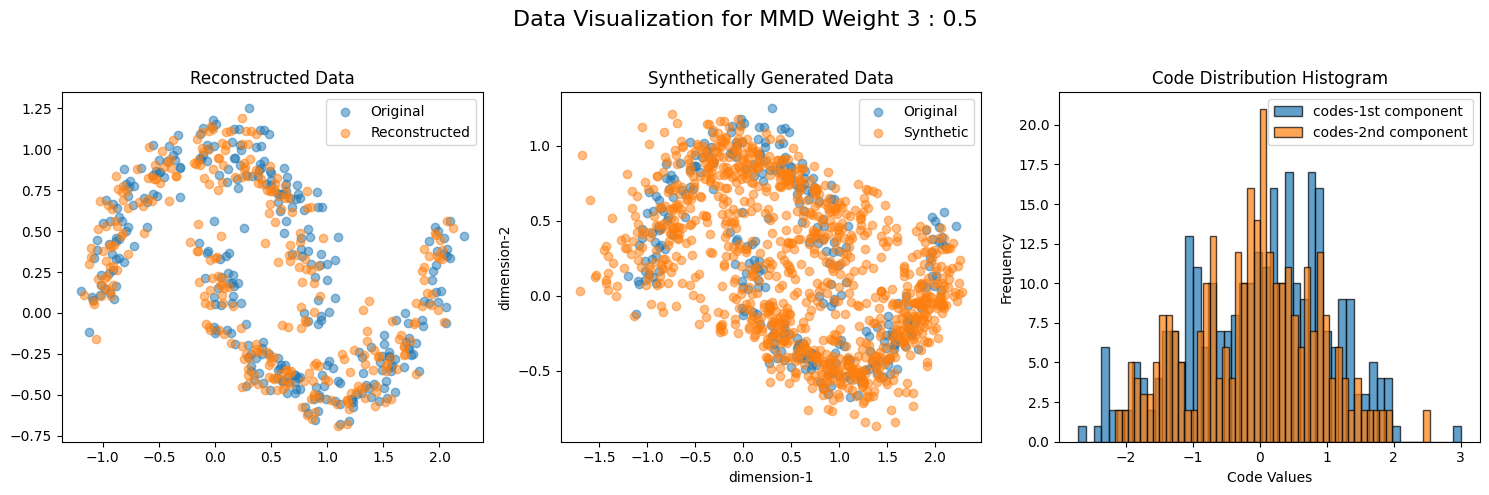

In [ ]:
# Function to train and visualize for different mmd_weight values
def train_and_visualize_for_mmd_weights(train_datasets, val_datasets,
                                        bandwidths=[0.1, 0.2, 0.4, 0.6, 0.8, 1.6],
                                        num_epochs=400, mmd_weights=[0.1, 0.2, 0.5]):
    for i, mmd_weight in enumerate(mmd_weights):
        # Reset your autoencoder model
        model = Autoencoder(input_size=2, bottleneck_size=2, hidden_size=32, layers=3)
        print(f"\nTraining and Visualizing for MMD Weight {i + 1}: {mmd_weight}")
        _, _ = train_mmd_autoencoder(model, train_datasets, val_datasets,
                                     dataset_size=1000, num_epochs=num_epochs,
                                     batch_size=32, learning_rate=0.001,
                                     mmd_weight=mmd_weight, bandwidths=bandwidths,
                                     kernel_fn=squared_exponentials_kernel, wanna_print_loss=True)

        # Get the data loader for the validation set
        val_loader = torch.utils.data.DataLoader(val_datasets[1000]['X'], batch_size=32, shuffle=True)

        # Visualize reconstructed data, synthetically generated data, and individual components for the current mmd_weight
        plt.figure(figsize=(15, 5))
        plt.suptitle(f'Data Visualization for MMD Weight {i + 1} : {mmd_weight}', fontsize=16)

        # Subplot 1: Reconstructed Data
        plt.subplot(1, 3, 1)
        visualize_reconstructed_data(model, val_datasets[1000]['X'])
        plt.title('Reconstructed Data')

        # Subplot 2: Synthetically Generated Data
        plt.subplot(1, 3, 2)
        synthetic_data = generate_synthetic_data(model, num_samples=1000)
        visualize_synthetic_data(val_datasets[1000]['X'], synthetic_data)
        plt.title('Synthetically Generated Data')

        # Subplot 3: Visualize Individual Components
        plt.subplot(1, 3, 3)
        visualize_code_distribution_histogram_indiv_component(model, val_loader)

        plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to prevent overlapping subplots
        plt.show()

# Example usage:
train_and_visualize_for_mmd_weights(train_datasets, val_datasets, num_epochs=400)


After setting these values for number of epochs and bandwidth list, we varied the value of *mmd_weight*.

* We found that in general, on increasing the value of mmd_weight (lambda), the reconstruction error increased

<div style="color: green; font-weight:
bold">Comment:</div>

* Unlike the sample solution, what we observed is that on increasing the mmd_weight factor, the reconstruction error increases.

* Quality of the Synthetically generated dataset: Our observations are consistent with the sample solution i.e. although the mmd_squared loss decreases, the decrease is not dramatic!

<div style="color: green; font-weight:
bold">Comment:</div>

We could have also analysed the effect of increasing the number of layers in our model. However since it was not asked for explicitly in the task 2 of the assignment, we didnt do it.

### Running final experiment for task-2

<div style="color: green; font-weight:
bold">Comment:</div> We could have chosen higher value of the mmd_weight!

In [ ]:
input_size = 2  # make_moons dataset is 2-Dimensional.
bottleneck_size = 2 # no bottleneck case
hidden_size = 32
layers = 3

# instantiating our autoencoder model
autoencoder_model = Autoencoder(input_size, bottleneck_size, hidden_size, layers)


# Training the autoencoder using train_mmd_autoencoder function using squared exponentials kernel
epoch_train_loss_1, epoch_val_loss_1=train_mmd_autoencoder(autoencoder_model, train_datasets,
                                                           val_datasets, dataset_size=1000,
                                                           num_epochs=500, batch_size=32,
                                                           learning_rate=0.001, mmd_weight=0.1,
                                                           bandwidths=[0.1,0.2,0.4,0.6,1.2],
                                                           kernel_fn=squared_exponentials_kernel, print_loss_after_every_epoch=50)

Epoch [50/500], Recon Loss: 0.0006, MMD sqd Loss: 0.3527
Epoch [100/500], Recon Loss: 0.0008, MMD sqd Loss: 0.3316
Epoch [150/500], Recon Loss: 0.0005, MMD sqd Loss: 0.3492
Epoch [200/500], Recon Loss: 0.0004, MMD sqd Loss: 0.3432
Epoch [250/500], Recon Loss: 0.0007, MMD sqd Loss: 0.3536
Epoch [300/500], Recon Loss: 0.0006, MMD sqd Loss: 0.3372
Epoch [350/500], Recon Loss: 0.0007, MMD sqd Loss: 0.3055
Epoch [400/500], Recon Loss: 0.0004, MMD sqd Loss: 0.3272
Epoch [450/500], Recon Loss: 0.0007, MMD sqd Loss: 0.3274
Epoch [500/500], Recon Loss: 0.0004, MMD sqd Loss: 0.3290


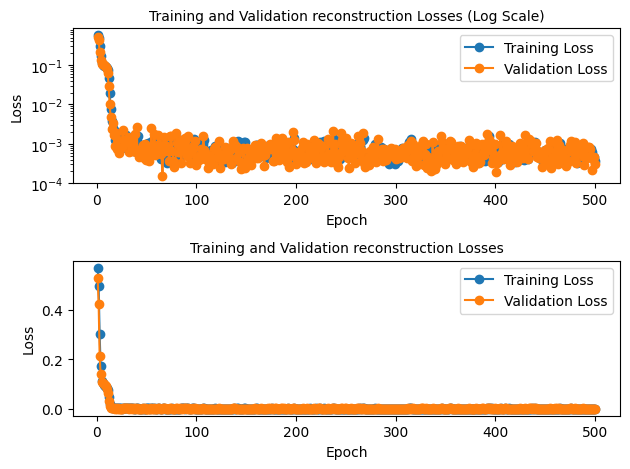

In [ ]:
#print("considering the case when we only consider the reconstruction loss as batch loss")
plt.subplot(2,1,1)
plot_losses(epoch_train_loss_1,epoch_val_loss_1)
plt.subplot(2,1,2)
plot_losses(epoch_train_loss_1,epoch_val_loss_1,want_log_scale=False)
plt.tight_layout()

### Tasks we need to do:

1. Visualise the reconstructed vs. the original data
2. Visualise the code distribution
2. Generate the synthetic data by passing the standard normal samples through the decoder and visualise their quality.

### 2.1 Reconstructing the data and visualising it:

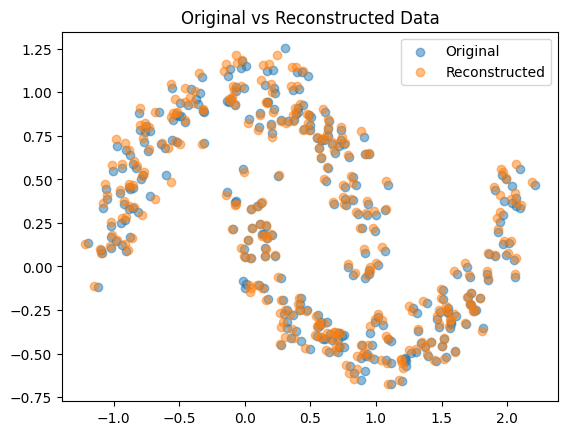

In [ ]:
# Visualize results on the test dataset
dataset_size=1000
visualize_reconstructed_data(autoencoder_model, val_datasets[dataset_size]['X'])

### 2.2 Synthetic data and its visualization:

dataset_size is: 1000


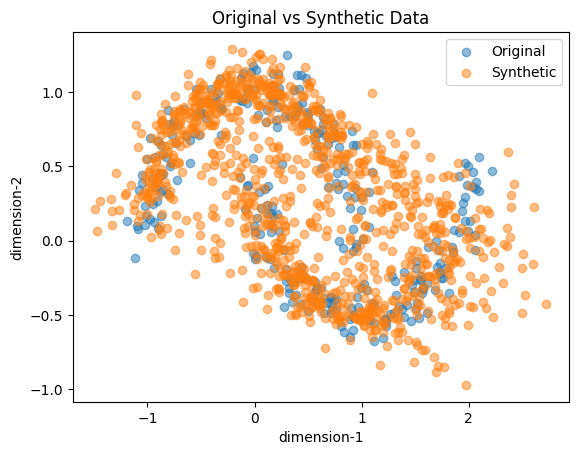

In [ ]:
print("dataset_size is:",dataset_size)
synthetic_data = generate_synthetic_data(autoencoder_model,num_samples=dataset_size)
visualize_synthetic_data(val_datasets[dataset_size]['X'], synthetic_data)

### 2.3: Visualising the Code distribution:


In [ ]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

In [ ]:
def visualize_code_distribution_3d_histogram(model, data_loader):
    model.eval()

    # Create empty list to store code representations
    code_list = []

    # Iterate over batches in the data loader and extract code representations
    with torch.no_grad():
        for data in data_loader:
            outputs = model.encoder(data)
            code_list.append(outputs.numpy())

    # Concatenate code representations from all batches
    all_codes = np.concatenate(code_list, axis=0)

    # Visualize 3D histogram
    fig = plt.figure(figsize=(10,15))
    ax = fig.add_subplot(111, projection='3d')
    hist, x_edges, y_edges = np.histogram2d(all_codes[:, 0], all_codes[:, 1], bins=50)

    # Create meshgrid for 3D bar plot
    x_centers = (x_edges[:-1] + x_edges[1:]) / 2
    y_centers = (y_edges[:-1] + y_edges[1:]) / 2
    x, y = np.meshgrid(x_centers, y_centers, indexing='ij')

    # Plot 3D histogram
    ax.bar3d(x.ravel(), y.ravel(), np.zeros_like(x.ravel()), 1, 1, hist.ravel(), shade=True)

    # Set viewing angle
    ax.view_init(elev=40, azim=40)

    # Add labels and title
    ax.set_xlabel('Code Dimension 1')
    ax.set_ylabel('Code Dimension 2')
    ax.set_zlabel('Frequency')
    ax.set_title('Code Distribution 3D Histogram')

    # Show the plot
    plt.show()


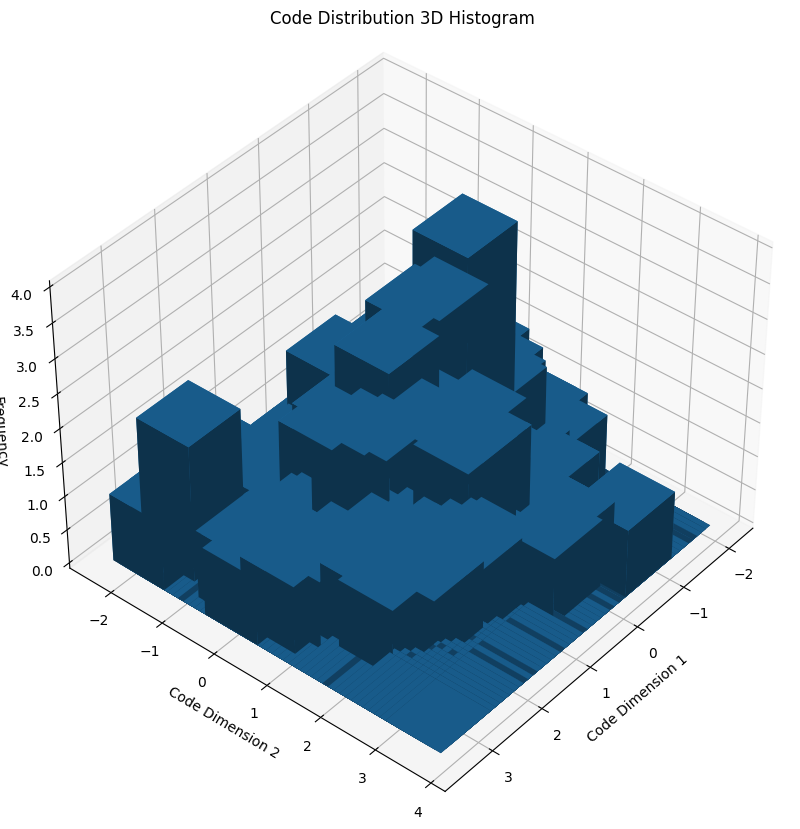

In [ ]:
val_loader = torch.utils.data.DataLoader(val_datasets[dataset_size]['X'], batch_size=32, shuffle=True)
visualize_code_distribution_3d_histogram(autoencoder_model, val_loader)

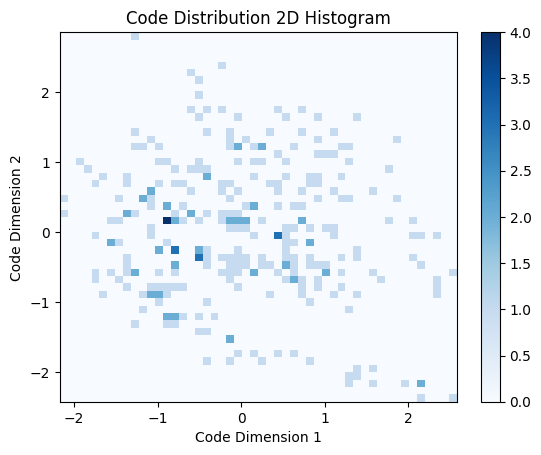

In [ ]:
### Visualising the code distribution as a 2-D histogram
visualize_code_distribution_2d_histogram(autoencoder_model, val_loader)

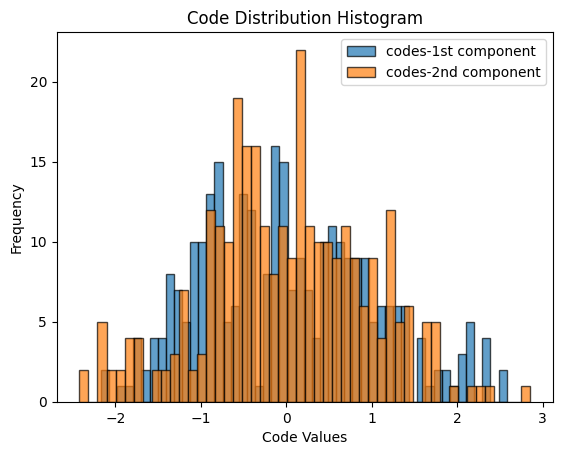

In [ ]:
#Visualizing each component of the 2-D code distribution as a histogram
visualize_code_distribution_histogram_indiv_component(autoencoder_model, val_loader)

<div style="color: green; font-weight:
bold">GENERAL COMMENT FOR THE TASK-2</div>

* We implemented everything that was asked for as well as analysed the effect of different combination of hyperparameters, just the it was asked in the problem. All (except one: increase in mmd_wt increases the reconstruction error in our case whereas it doesnt in the sampe solution) of our observations are consistent with that of the sample solution. We should have implemented the resnet as clearly it is giving better results than ours.

* The way we have implemented the code is similar and as fast as solution's.

* As mentioned above already, it would have been way better had we plotted the 2d histogram of the code distribtuion (or a simple scatter plot of the code distribution). (We had already defined the function to achieve this task). It would have provided us with a better idea of how the code distribution changes for diffeernt set of hyperparameters. Also we would have observed (visually) how the code distn and synthetic dataset are related (When we sample codes from a standard normal, the 'gaps' in the code distribution lead to generated data points between the moons (and not the 2-arcs of the moon), where they don't belong). (**Although our observation regrading the 2d histogram distribution of both the components of the code distribution being heavily tailed for bad choices of hyperparameters is also a good observation !!!**)

* Overall, although the way we have presented our results is as good as the sample solution. The reason we feel the sample solution seems to have an edge over our solution is mainly due to 1. choice of the model and 2. the code distribution plot as it beautifully it shows the relation b/w the synthetic data representation in 2 different spaces (code space and the space of the dataset). Other than that b

# 3. Higher-dimensional data

In [ ]:
from sklearn.datasets import load_digits

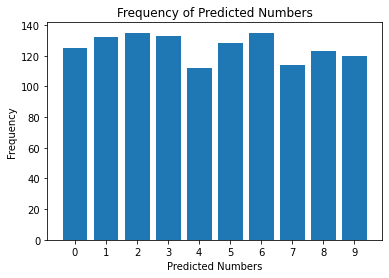

In [ ]:
digits = load_digits()
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.3)
train_dataset = {'X': torch.FloatTensor(X_train), 'y': y_train}
val_dataset = {'X': torch.FloatTensor(X_test), 'y': y_test}

# Count the frequency of each number from 0 to 9 in y_pred_gauss
count = np.bincount(y_train)

# Create a bar chart to visualize the frequencies
plt.bar(range(10), count)
plt.xticks(range(10))
plt.xlabel("Predicted Numbers")
plt.ylabel("Frequency")
plt.title("Frequency of Predicted Numbers")
plt.show()


<div style="color: green; font-weight:bold">Comment</div>
We created datasets of varying sizes, which is not present in the sample solution, but was a requirement by the exercise sheet. Also we didn't implement a standard scaler, however, it wasn't required by the task.

In [ ]:
# Training function
def train_autoencoder(model, train_dataset, test_dataset, dataset_size=1.0, num_epochs=100, batch_size=32, learning_rate=0.001):

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    X_train = train_dataset['X']
    X_test = test_dataset['X']

    if dataset_size < 1.0:
        X_train, _ = train_test_split(X_train, test_size=1-dataset_size)

    # Data loader
    train_loader = torch.utils.data.DataLoader(X_train, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(X_test, batch_size=batch_size, shuffle=True)

    epoch_train_losses = []  # List to store the loss for each epoch
    epoch_val_losses = []  # List to store the loss for each epoch
    for epoch in range(num_epochs):
        train_batch_losses = []
        val_batch_losses = []
        for batch in train_loader:
            # Forward pass
            outputs = model(batch)

            # Compute the loss
            loss = criterion(outputs, batch)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_batch_losses.append(loss.item())

        for batch in val_loader:
            outputs = model(batch)
            loss = criterion(outputs, batch)
            val_batch_losses.append(loss.item())

        # Calculate and store the mean loss for the epoch
        epoch_train_loss = sum(train_batch_losses) / len(train_batch_losses)
        epoch_train_losses.append(epoch_train_loss)

        epoch_val_loss = sum(val_batch_losses) / len(val_batch_losses)
        epoch_val_losses.append(epoch_val_loss)
        # Print the mean loss every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_train_loss:.4f}')
    return epoch_train_losses, epoch_val_losses

Epoch [10/200], Loss: 18.4600
Epoch [20/200], Loss: 14.3314
Epoch [30/200], Loss: 10.7488
Epoch [40/200], Loss: 9.2260
Epoch [50/200], Loss: 7.8948
Epoch [60/200], Loss: 6.3145
Epoch [70/200], Loss: 5.4887
Epoch [80/200], Loss: 5.0071
Epoch [90/200], Loss: 4.6692
Epoch [100/200], Loss: 4.3920
Epoch [110/200], Loss: 4.1611
Epoch [120/200], Loss: 3.8126
Epoch [130/200], Loss: 3.6389
Epoch [140/200], Loss: 3.4762
Epoch [150/200], Loss: 3.2807
Epoch [160/200], Loss: 3.0617
Epoch [170/200], Loss: 3.0807
Epoch [180/200], Loss: 2.8661
Epoch [190/200], Loss: 2.6549
Epoch [200/200], Loss: 2.5009
Epoch [10/200], Loss: 15.5529
Epoch [20/200], Loss: 8.3709
Epoch [30/200], Loss: 6.5321
Epoch [40/200], Loss: 5.6199
Epoch [50/200], Loss: 5.2140
Epoch [60/200], Loss: 4.7185
Epoch [70/200], Loss: 4.4281
Epoch [80/200], Loss: 4.2409
Epoch [90/200], Loss: 3.9243
Epoch [100/200], Loss: 3.7587
Epoch [110/200], Loss: 3.6009
Epoch [120/200], Loss: 3.5346
Epoch [130/200], Loss: 3.3265
Epoch [140/200], Loss: 3

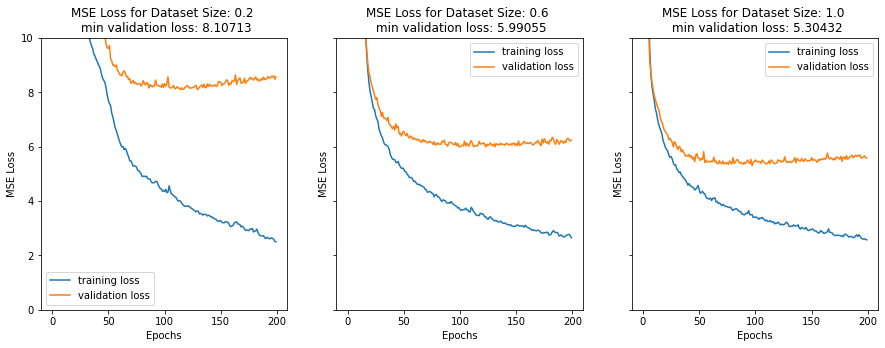

In [ ]:
dataset_sizes = [0.2, 0.6, 1.0]  # Fraction of the original dataset size
input_size = 64
bottleneck_size = 4
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
for i, dataset_size in enumerate(dataset_sizes):
    autoencoder = Autoencoder(input_size, bottleneck_size, hidden_size = 200, layers = 2)
    train_losses, val_losses = train_autoencoder(autoencoder, train_dataset,val_dataset, dataset_size=dataset_size, num_epochs=200)
    axes[i].plot(train_losses, label='training loss')
    axes[i].plot(val_losses, label='validation loss')
    axes[i].set_title('MSE Loss for Dataset Size: {} \n min validation loss: {:.5f}'.format(dataset_size, min(val_losses)))
    axes[i].set_xlabel('Epochs')
    axes[i].set_ylabel('MSE Loss')
    axes[i].set_ylim(0, 10)
    axes[i].legend()



We can see we are already overfitting the data at around 100 Epochs. The min validation loss was acieved by the full dataset, therefore we are going to persue with this one

Epoch [10/300], Loss: 10.3948
Epoch [20/300], Loss: 6.6469
Epoch [30/300], Loss: 5.7388
Epoch [40/300], Loss: 5.1717
Epoch [50/300], Loss: 4.7633
Epoch [60/300], Loss: 4.5159
Epoch [70/300], Loss: 4.2882
Epoch [80/300], Loss: 4.1495
Epoch [90/300], Loss: 4.0150
Epoch [100/300], Loss: 3.8533
Epoch [110/300], Loss: 3.7301
Epoch [120/300], Loss: 3.6201
Epoch [130/300], Loss: 3.5265
Epoch [140/300], Loss: 3.4207
Epoch [150/300], Loss: 3.3819
Epoch [160/300], Loss: 3.3100
Epoch [170/300], Loss: 3.2378
Epoch [180/300], Loss: 3.1446
Epoch [190/300], Loss: 3.0776
Epoch [200/300], Loss: 2.9946
Epoch [210/300], Loss: 2.9482
Epoch [220/300], Loss: 2.9546
Epoch [230/300], Loss: 2.8376
Epoch [240/300], Loss: 2.8415
Epoch [250/300], Loss: 2.7779
Epoch [260/300], Loss: 2.7497
Epoch [270/300], Loss: 2.7317
Epoch [280/300], Loss: 2.6884
Epoch [290/300], Loss: 2.6182
Epoch [300/300], Loss: 2.5940
Epoch [10/300], Loss: 9.4048
Epoch [20/300], Loss: 6.6952
Epoch [30/300], Loss: 5.7525
Epoch [40/300], Loss:

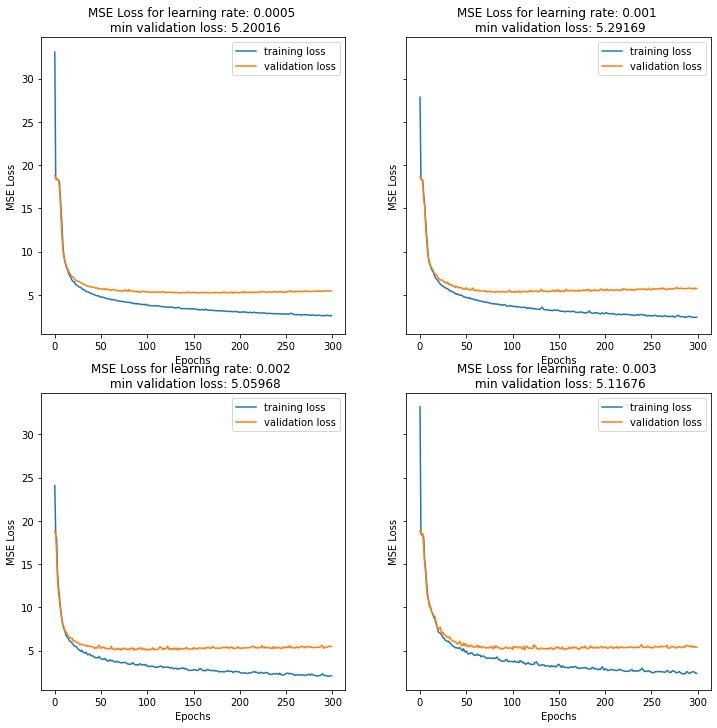

In [ ]:
learning_rates = [0.0005, 0.001, 0.002 ,0.003]
fig, axes = plt.subplots(2, 2, figsize=(12, 12), sharey=True)
for i, learning_rate in enumerate(learning_rates):
    autoencoder = Autoencoder(input_size, bottleneck_size, hidden_size = 200, layers = 2)
    train_losses, val_losses = train_autoencoder(autoencoder, train_dataset,val_dataset, dataset_size=1.0, num_epochs=300, learning_rate=learning_rate)

    # Use two indices to access the correct subplot
    row = i // 2  # Integer division to get the row index
    col = i % 2   # Modulo operation to get the column index

    axes[row, col].plot(train_losses, label='training loss')
    axes[row, col].plot(val_losses, label='validation loss')
    axes[row, col].set_title('MSE Loss for learning rate: {} \n min validation loss: {:.5f}'.format(learning_rate, min(val_losses)))
    axes[row, col].set_xlabel('Epochs')
    axes[row, col].set_ylabel('MSE Loss')
    axes[row, col].legend()

The learning rate does not have a huge impact on the current architecture and we choose for now the best performung learning rate of 0.002. Next, we are going to look at different architectures, but with constant bottleneck size = 4 for now

Epoch [10/300], Loss: 16.4840
Epoch [20/300], Loss: 11.3524
Epoch [30/300], Loss: 9.7522
Epoch [40/300], Loss: 8.1971
Epoch [50/300], Loss: 7.2533
Epoch [60/300], Loss: 6.8407
Epoch [70/300], Loss: 6.5967
Epoch [80/300], Loss: 6.4128
Epoch [90/300], Loss: 6.0955
Epoch [100/300], Loss: 5.9026
Epoch [110/300], Loss: 5.7700
Epoch [120/300], Loss: 5.5504
Epoch [130/300], Loss: 5.5048
Epoch [140/300], Loss: 5.3809
Epoch [150/300], Loss: 5.3357
Epoch [160/300], Loss: 5.2326
Epoch [170/300], Loss: 5.1443
Epoch [180/300], Loss: 5.0627
Epoch [190/300], Loss: 4.9560
Epoch [200/300], Loss: 4.9804
Epoch [210/300], Loss: 4.8816
Epoch [220/300], Loss: 4.8901
Epoch [230/300], Loss: 4.8214
Epoch [240/300], Loss: 4.7185
Epoch [250/300], Loss: 4.6735
Epoch [260/300], Loss: 4.7438
Epoch [270/300], Loss: 4.6220
Epoch [280/300], Loss: 4.5778
Epoch [290/300], Loss: 4.6382
Epoch [300/300], Loss: 4.5190
Epoch [10/300], Loss: 18.2769
Epoch [20/300], Loss: 18.2546
Epoch [30/300], Loss: 18.2430
Epoch [40/300], L

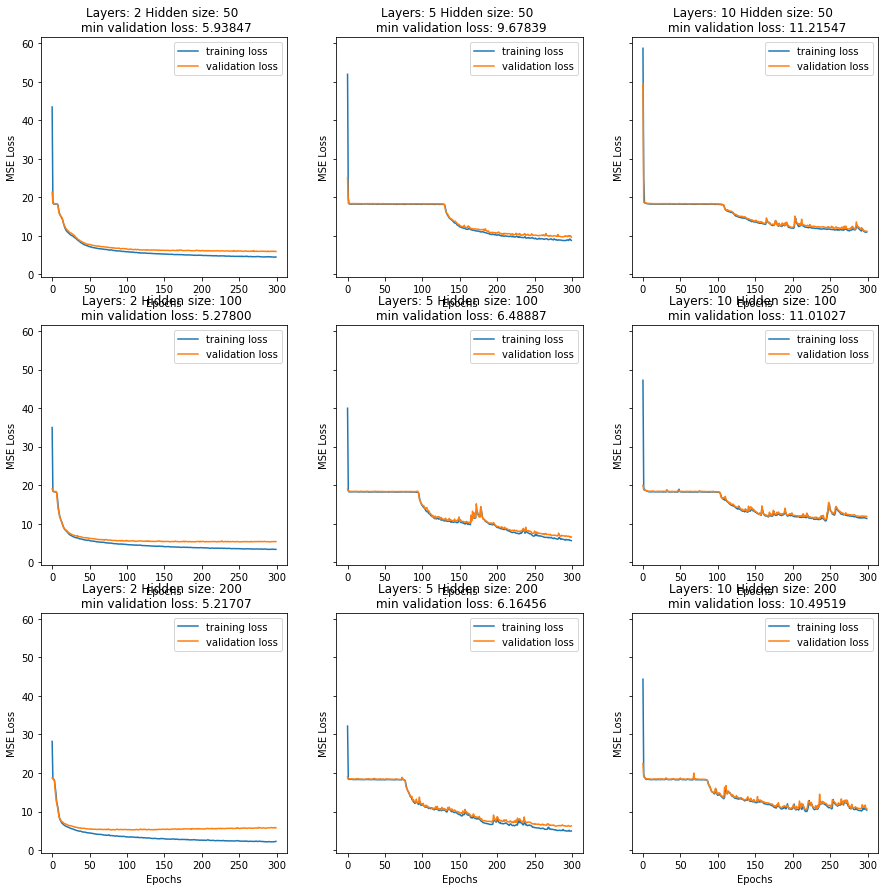

In [ ]:
hidden_sizes = [50, 100, 200]
layers = [2,5,10]
fig, axes = plt.subplots(3, 3, figsize=(15, 15), sharey=True)
for i, hidden_size in enumerate(hidden_sizes):
    for j, num_layers in enumerate(layers):

        autoencoder = Autoencoder(input_size, bottleneck_size, hidden_size = hidden_size, layers = num_layers)
        train_losses, val_losses = train_autoencoder(autoencoder, train_dataset,val_dataset, dataset_size=1.0, num_epochs=300, learning_rate=0.001)

        axes[i,j].plot(train_losses, label='training loss')
        axes[i,j].plot(val_losses, label='validation loss')
        axes[i,j].set_title('Layers: {} Hidden size: {} \n min validation loss: {:.5f}'.format(num_layers, hidden_size, min(val_losses)))
        axes[i,j].set_xlabel('Epochs')
        axes[i,j].set_ylabel('MSE Loss')
        axes[i,j].legend()


The tested network with 5 or 10 layers all have a strange plateo, where the loss is more or less constant and after around 60 epochs start improving again. It seems the best network structure from those which we have tested is again 2 layers and the biggest tested hidden size of 200, so lets test if a increased hidden size still improves the results

Epoch [10/70], Loss: 7.1132
Epoch [20/70], Loss: 5.4070
Epoch [30/70], Loss: 4.8553
Epoch [40/70], Loss: 4.3267
Epoch [50/70], Loss: 4.0164
Epoch [60/70], Loss: 3.6175
Epoch [70/70], Loss: 3.3985


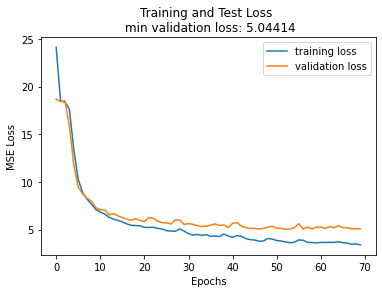

In [ ]:
best_autoencoder = Autoencoder(input_size, bottleneck_size, hidden_size = 400, layers = 2)
train_losses, val_losses = train_autoencoder(best_autoencoder, train_dataset,val_dataset, dataset_size=1.0, num_epochs=70, learning_rate=0.002)
plt.plot(train_losses, label='training loss')
plt.plot(val_losses, label='validation loss')
plt.title('Training and Test Loss \n min validation loss: {:.5f}'.format(min(val_losses)))
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()


The validation loss of this model with hidden size 400 is still platoing after around 100 epoch and the minimum validation loss is still around 5, but since the validation loss improved, we try a even bigger hidden size of 800

Epoch [10/200], Loss: 13.0530
Epoch [20/200], Loss: 6.2587
Epoch [30/200], Loss: 5.0509
Epoch [40/200], Loss: 4.6476
Epoch [50/200], Loss: 4.4377
Epoch [60/200], Loss: 4.1626
Epoch [70/200], Loss: 4.1874
Epoch [80/200], Loss: 3.7587
Epoch [90/200], Loss: 3.6998
Epoch [100/200], Loss: 3.6286
Epoch [110/200], Loss: 3.5767
Epoch [120/200], Loss: 3.5247
Epoch [130/200], Loss: 3.2418
Epoch [140/200], Loss: 3.1012
Epoch [150/200], Loss: 3.1125
Epoch [160/200], Loss: 3.0120
Epoch [170/200], Loss: 2.8734
Epoch [180/200], Loss: 2.8917
Epoch [190/200], Loss: 2.6362
Epoch [200/200], Loss: 2.5691


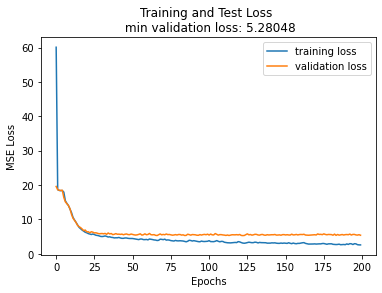

In [ ]:
autoencoder = Autoencoder(input_size, bottleneck_size, hidden_size = 800, layers = 2)
train_losses, val_losses = train_autoencoder(autoencoder, train_dataset,val_dataset, dataset_size=1.0, num_epochs=200, learning_rate=0.002)
plt.plot(train_losses, label='training loss')
plt.plot(val_losses, label='validation loss')
plt.title('Training and Test Loss \n min validation loss: {:.5f}'.format(min(val_losses)))
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

Now we dont see any improvement anymore, so we stick with the model of 2 layers and hidden size of 400. Let finally plot some samples and look into the bottleneck size

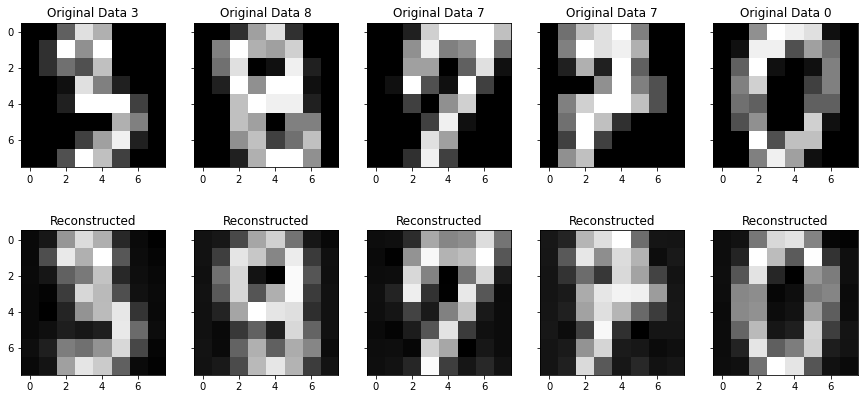

In [ ]:
val_data = val_dataset['X'][:5]
val_labels = val_dataset['y'][:5]
with torch.no_grad():
    reconstructed_data = best_autoencoder(val_data)

# Convert PyTorch tensors to numpy arrays
data_np = val_data.numpy()
reconstructed_np = reconstructed_data.numpy()

fig, axes = plt.subplots(2, 5, figsize=(15, 7), sharey=True)
for k in range(5):
    axes[0, k].imshow(data_np[k].reshape(8, 8), cmap=plt.cm.gray)
    axes[0, k].set_title(f"Original Data {val_labels[k]}")
    axes[1, k].imshow(reconstructed_np[k].reshape(8, 8), cmap=plt.cm.gray)
    axes[1, k].set_title(f"Reconstructed")

plt.show()

The results are looking pretty good! Lets look into the influence of the bottleneck size

Epoch [10/200], Loss: 12.4592
Epoch [20/200], Loss: 11.0965
Epoch [30/200], Loss: 10.5375
Epoch [40/200], Loss: 9.7942
Epoch [50/200], Loss: 8.8697
Epoch [60/200], Loss: 8.5477
Epoch [70/200], Loss: 8.5726
Epoch [80/200], Loss: 8.2404
Epoch [90/200], Loss: 7.6579
Epoch [100/200], Loss: 7.4886
Epoch [110/200], Loss: 7.1685
Epoch [120/200], Loss: 6.8875
Epoch [130/200], Loss: 6.7129
Epoch [140/200], Loss: 6.3500
Epoch [150/200], Loss: 6.4551
Epoch [160/200], Loss: 5.7057
Epoch [170/200], Loss: 5.4821
Epoch [180/200], Loss: 5.3485
Epoch [190/200], Loss: 5.2245
Epoch [200/200], Loss: 5.1916


C:\Users\luke\AppData\Local\Temp\ipykernel_12092\2827622719.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_sub.show()


Epoch [10/200], Loss: 6.9690
Epoch [20/200], Loss: 5.3208
Epoch [30/200], Loss: 4.5750
Epoch [40/200], Loss: 4.1916
Epoch [50/200], Loss: 3.8340
Epoch [60/200], Loss: 3.5518
Epoch [70/200], Loss: 3.3979
Epoch [80/200], Loss: 3.2425
Epoch [90/200], Loss: 3.0083
Epoch [100/200], Loss: 2.8266
Epoch [110/200], Loss: 2.7763
Epoch [120/200], Loss: 2.7148
Epoch [130/200], Loss: 2.5763
Epoch [140/200], Loss: 2.5259
Epoch [150/200], Loss: 2.3964
Epoch [160/200], Loss: 2.3757
Epoch [170/200], Loss: 2.2138
Epoch [180/200], Loss: 2.1104
Epoch [190/200], Loss: 2.0981
Epoch [200/200], Loss: 1.9651
Epoch [10/200], Loss: 6.0441
Epoch [20/200], Loss: 3.7071
Epoch [30/200], Loss: 2.7195
Epoch [40/200], Loss: 2.1967
Epoch [50/200], Loss: 1.8577
Epoch [60/200], Loss: 1.6153
Epoch [70/200], Loss: 1.4481
Epoch [80/200], Loss: 1.3014
Epoch [90/200], Loss: 1.2099
Epoch [100/200], Loss: 1.1232
Epoch [110/200], Loss: 1.0713
Epoch [120/200], Loss: 0.9913
Epoch [130/200], Loss: 0.8700
Epoch [140/200], Loss: 0.850

C:\Users\luke\AppData\Local\Temp\ipykernel_12092\2827622719.py:32: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


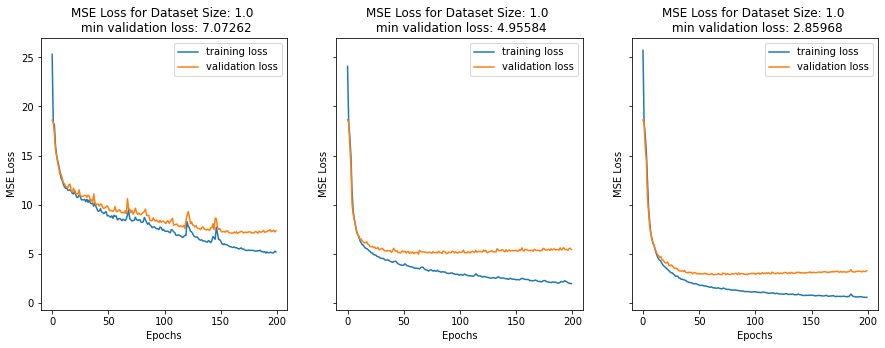

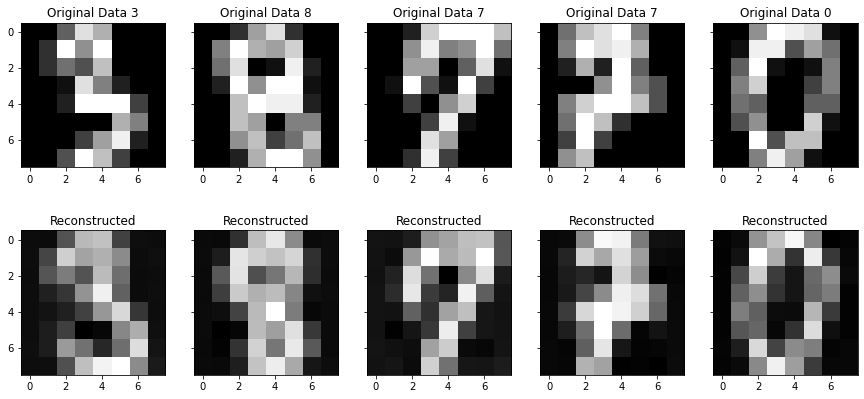

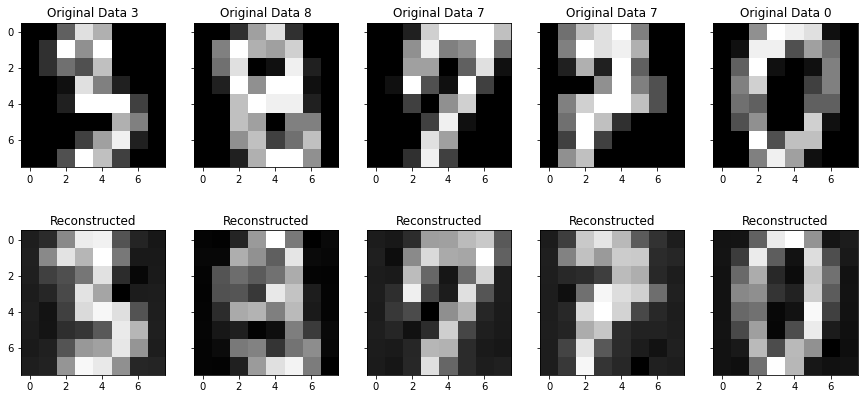

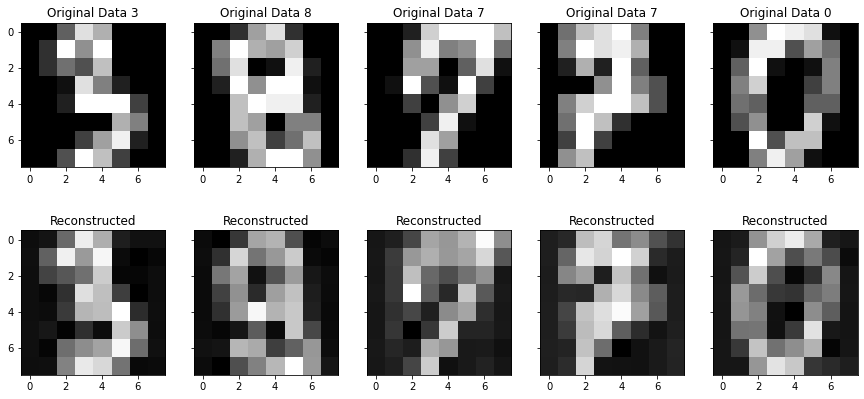

In [ ]:
bottleneck_sizes = [2,4,8]
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
# Visualization subplot
val_data = val_dataset['X'][:5]
val_labels = val_dataset['y'][:5]

for i, bottleneck_size in enumerate(bottleneck_sizes):
    autoencoder = Autoencoder(input_size, bottleneck_size, hidden_size = 400, layers = 2)
    train_losses, val_losses = train_autoencoder(autoencoder, train_dataset,val_dataset, dataset_size=dataset_size, num_epochs=200)
    axes[i].plot(train_losses, label='training loss')
    axes[i].plot(val_losses, label='validation loss')
    axes[i].set_title('MSE Loss for Dataset Size: {} \n min validation loss: {:.5f}'.format(dataset_size, min(val_losses)))
    axes[i].set_xlabel('Epochs')
    axes[i].set_ylabel('MSE Loss')
    axes[i].legend()

    with torch.no_grad():
        reconstructed_data = autoencoder(val_data)

    # Convert PyTorch tensors to numpy arrays
    data_np = val_data.numpy()
    reconstructed_np = reconstructed_data.numpy()

    # Subplot for original and reconstructed images
    fig_sub, axes_sub = plt.subplots(2, 5, figsize=(15, 7), sharey=True)
    for k in range(5):
        axes_sub[0, k].imshow(data_np[k].reshape(8, 8), cmap=plt.cm.gray)
        axes_sub[0, k].set_title(f"Original Data {val_labels[k]}")
        axes_sub[1, k].imshow(reconstructed_np[k].reshape(8, 8), cmap=plt.cm.gray)
        axes_sub[1, k].set_title(f"Reconstructed")
    fig_sub.show()
fig.show()

The bigger the bottleneck size, the more of the original data can be restored, but also more background noise starts to appear, but all digits can still be visually guessed



<div style="color: green; font-weight:bold">Comment</div>
The sample solution completly misses the hyperparameter optimization and analysis of different dataset sizes.

## Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
from sklearn.metrics import accuracy_score

val_data = val_dataset['X']
val_labels = val_dataset['y']
y_pred_original = rf_classifier.predict(val_data)
with torch.no_grad():
    reconstructed_data = best_autoencoder(val_data)
y_pred_reconstructed = rf_classifier.predict(reconstructed_data)
accuracy_original = accuracy_score(val_labels, y_pred_original)
print(f"Accuracy of original predictions: {accuracy_original:.2f}")
accuracy_reconstructed = accuracy_score(val_labels, y_pred_reconstructed)
print(f"Accuracy of reconstructed predictions: {accuracy_reconstructed:.2f}")
same_predictions = np.sum(y_pred_original == y_pred_reconstructed)
different_predictions = np.sum(y_pred_original != y_pred_reconstructed)

print("The Classifier predicted {}-times the same label for original and reconstructed data and {}-times a different one".format(same_predictions, different_predictions))

Accuracy of original predictions: 0.97
Accuracy of reconstructed predictions: 0.92
The Classifier predicted 499-times the same label for original and reconstructed data and 41-times a different one


Train a classifier with bottleneck 2

In [ ]:
autoencoder_2 = Autoencoder(input_size, bottleneck_size=2, hidden_size = 400, layers = 2)
train_losses, val_losses = train_autoencoder(autoencoder_2, train_dataset,val_dataset, dataset_size=1.0, num_epochs=70, learning_rate=0.002)

Epoch [10/70], Loss: 12.2840
Epoch [20/70], Loss: 10.4991
Epoch [30/70], Loss: 9.6726
Epoch [40/70], Loss: 9.1133
Epoch [50/70], Loss: 7.7206
Epoch [60/70], Loss: 6.9760
Epoch [70/70], Loss: 7.2024


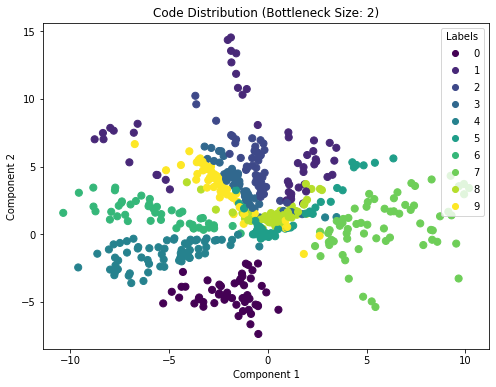

In [ ]:
with torch.no_grad():
    val_data = val_dataset['X']  # Choose a subset for visualization
    code_representation = autoencoder_2.encoder(val_data).numpy()

# Assuming you have labels for the validation data
labels = val_dataset['y']  # Choose a subset for visualization

# Create a scatter plot with labels as colors
plt.figure(figsize=(8, 6))
scatter = plt.scatter(code_representation[:, 0], code_representation[:, 1], c=labels, cmap='viridis', s=50)
plt.title(f'Code Distribution (Bottleneck Size: 2)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(*scatter.legend_elements(), title='Labels', loc='upper right')
plt.show()

The same labels are represented in a space in 2D where each label represents a distinct area

<div style="color: green; font-weight:bold">Comment</div>
We correctly applied the Random Forest Classifier and plotted the code distribution for bottleneck size 2 as required, for some reason the sample solution also plots these for sizes 4 and 8. We are missing the fitting of a GMM